In [1]:
# CHECK WHAT GPU UR USING
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 30 10:33:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4500               On  |   00000000:C2:00.0 Off |                  Off |
| 30%   26C    P8             17W /  200W |       2MiB /  20470MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Install these critical packages for this project
!pip install SimpleITK
!pip install keras-preprocessing
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/a8/f3/62fc9a5a659bb58a03cdd7e258956a5824bdc9b4bb3c5d932f55880be569/scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/fc/da/452e1119e6f720df3feb588cce3c42c5e3d628d4bfd4aec097bd30b7de0c/scipy-1.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py

In [5]:
# Import all the packages u need
import keras
from keras.models import Model
import tensorflow as tf
from keras.layers import Input, Conv3D, BatchNormalization, Dropout, MaxPooling3D, UpSampling3D, Conv3DTranspose, Concatenate, Activation, Add
from keras.utils import to_categorical
import SimpleITK as sitk
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy
from keras import backend as K

DEFINE PREPROCESSING CODE. were taking class 4 and turning it to 0 so we have only 4 classes (0[the background],1,2, and 3)

In [6]:
import SimpleITK as sitk
import numpy as np
import tensorflow as tf

def preprocess_image_mask(image_file, mask_file):
    # Load NRRD files (image and mask)
    image = sitk.ReadImage(image_file.decode())
    mask = sitk.ReadImage(mask_file.decode())

    # Convert to NumPy arrays
    image = sitk.GetArrayFromImage(image)
    mask = sitk.GetArrayFromImage(mask)

    # Scale and convert image to float16
    img_min = np.min(image)
    img_max = np.max(image)
    if img_max > img_min:
        image = (image - img_min) / (img_max - img_min)
    image = image.astype(np.float16)  # Ensure image is float16
    image = np.expand_dims(image, axis=-1)

    # Convert class 4 to 0
    mask[mask == 4] = 0

    # Convert all classes > 0 to 1 for binary classification
    mask[mask > 0] = 1

    # Convert the mask to float16
    mask = mask.astype(np.float16)

    # Expand the mask dimensions to match the image dimensions
    mask = np.expand_dims(mask, axis=-1)

    return image, mask

In [7]:
# Set Parameters
batch_size = 20 
n_classes = 1
seed = 17

In [8]:
import tensorflow as tf
import glob
import numpy as np

def create_dataset(image_dir, mask_dir, batch_size):
    image_files = sorted(glob.glob(image_dir))
    mask_files = sorted(glob.glob(mask_dir))

    # Ensure both lists have the same length
    assert len(image_files) == len(mask_files), "Image and mask files lists must be the same length."

    # Generate indices and shuffle them
    indices = np.arange(len(image_files))
    np.random.shuffle(indices)

    # Use the shuffled indices to reorder the file lists
    shuffled_image_files = [image_files[i] for i in indices]
    shuffled_mask_files = [mask_files[i] for i in indices]

    # Create a TensorFlow dataset from the shuffled file names
    dataset = tf.data.Dataset.from_tensor_slices((shuffled_image_files, shuffled_mask_files))

    def _parse_function(image_file, mask_file):
        # Load image and mask as float16
        image, mask = tf.numpy_function(preprocess_image_mask, [image_file, mask_file], [tf.float16, tf.float16])
        image.set_shape([2000, 2000, 1])  # Adjusted for 2D shape
        mask.set_shape([2000, 2000, 1])   # Adjusted for 2D shape without one-hot encoding (binary classification)
        return image, mask

    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.repeat()

    return dataset

In [10]:
def calculate_class_frequencies(binary_mask_batch):
    # Flatten the mask batch to calculate the frequencies across the entire batch
    mask_flattened = tf.reshape(binary_mask_batch, [-1])
    
    # Convert mask to int32 for tf.math.bincount
    mask_flattened = tf.cast(mask_flattened, tf.int32)
    
    # Count the occurrences of each class (0 and 1)
    class_counts = tf.math.bincount(mask_flattened, minlength=2, maxlength=2)
    
    # Cast class_counts to float32 for consistent data type during division
    class_counts = tf.cast(class_counts, tf.float32)
    
    # Normalize the class counts to get the frequencies
    total_pixels = tf.reduce_sum(class_counts)
    class_frequencies = class_counts / total_pixels
    
    return class_frequencies.numpy()

# Define paths and batch size
train_img_dir = "/workspace/trainxray22/*.nrrd"
train_mask_dir = "/workspace/traingt2/*.nrrd"

# Create the dataset
dataset = create_dataset(train_img_dir, train_mask_dir, batch_size)

DEFINE YOUR TRAIN AND VALIDATION COMMANDS and print the shape of ur data so all looks good.

In [11]:
import numpy as np
import tensorflow as tf
import glob

def calculate_num_samples(image_dir, mask_dir):
    image_files = sorted(glob.glob(image_dir))
    mask_files = sorted(glob.glob(mask_dir))
    
    if len(image_files) != len(mask_files):
        raise ValueError("Number of image files and mask files do not match.")
    
    file_pairs = list(zip(image_files, mask_files))
    return len(file_pairs)

val_img_dir = "/workspace/valxray/*.nrrd"
val_mask_dir = "/workspace/valgt/*.nrrd"

# Calculate number of samples
num_train_samples = calculate_num_samples(train_img_dir, train_mask_dir)
num_val_samples = calculate_num_samples(val_img_dir, val_mask_dir)

# Create datasets
train_dataset = create_dataset(train_img_dir, train_mask_dir, batch_size)
val_dataset = create_dataset(val_img_dir, val_mask_dir, batch_size)

# Print sample counts
print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")

# Inspect the first batch
for img_batch, mask_batch in train_dataset.take(1):
    print("Training Image Batch Shape:", img_batch.shape)
    print("Training Mask Batch Shape:", mask_batch.shape)

Number of training samples: 12075
Number of validation samples: 2710
Training Image Batch Shape: (20, 2000, 2000, 1)
Training Mask Batch Shape: (20, 2000, 2000, 1)


PLOT YOUR XRAYS AND GTs SIDE BY SIDE TO CONFIRM ALL IS GOOD

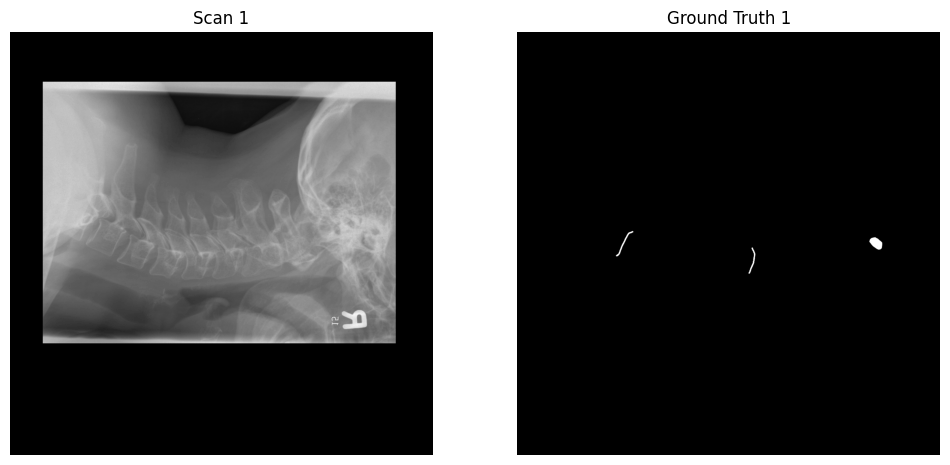

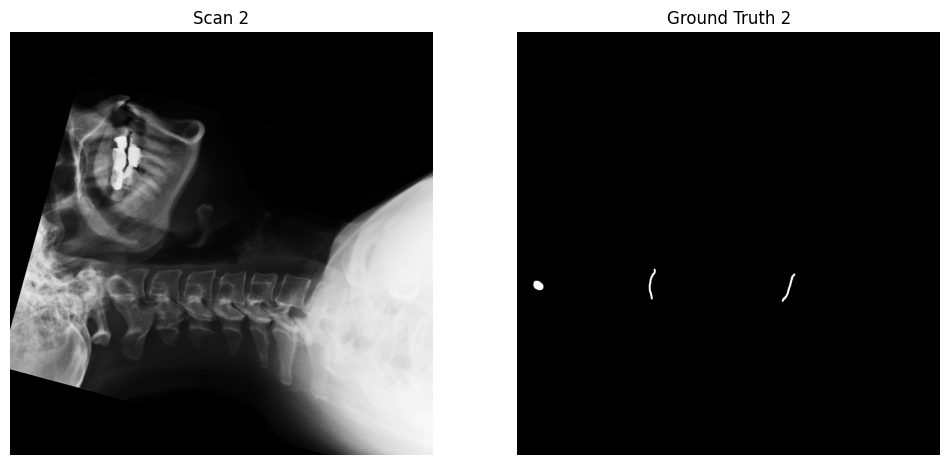

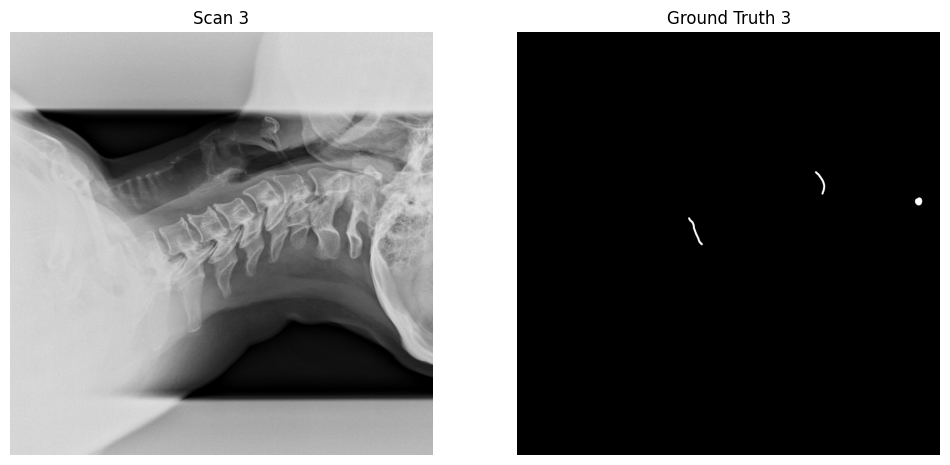

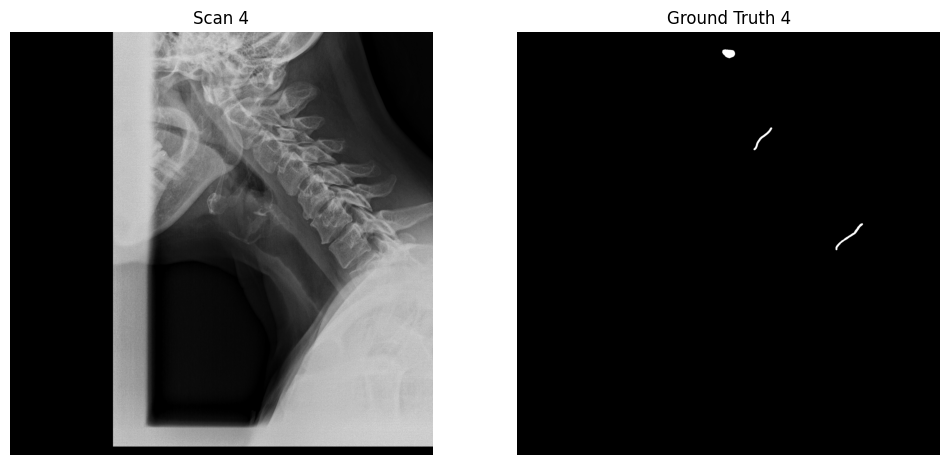

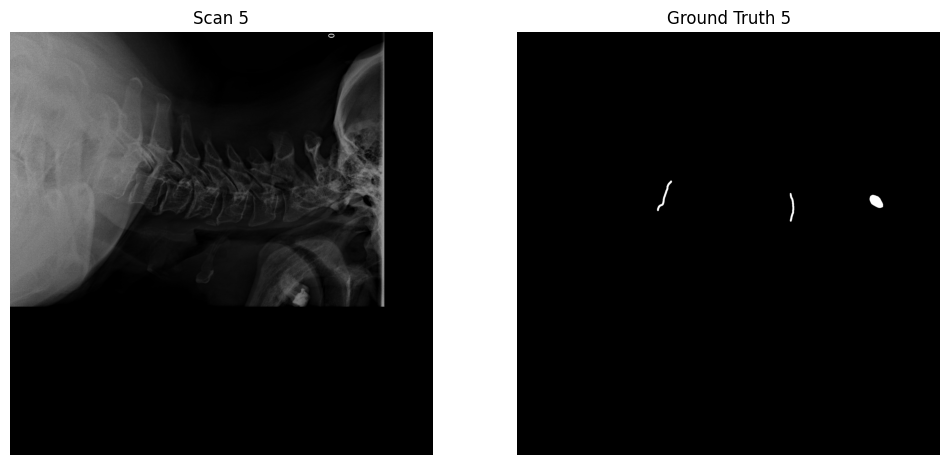

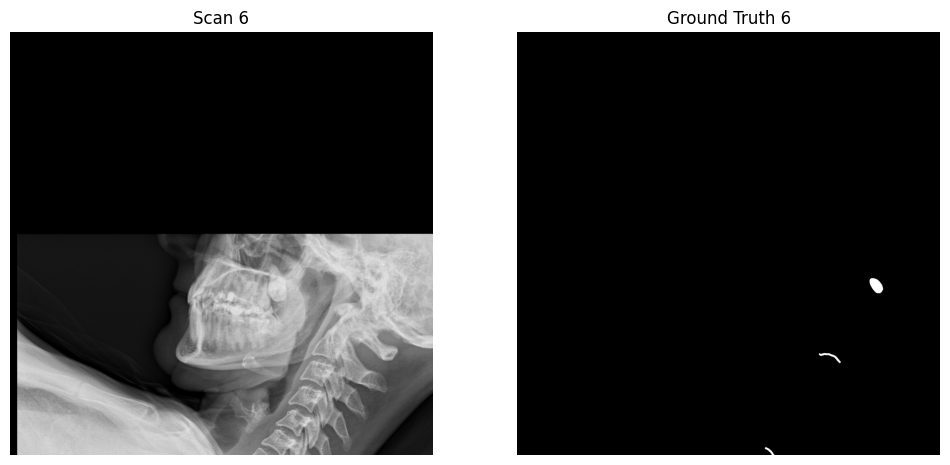

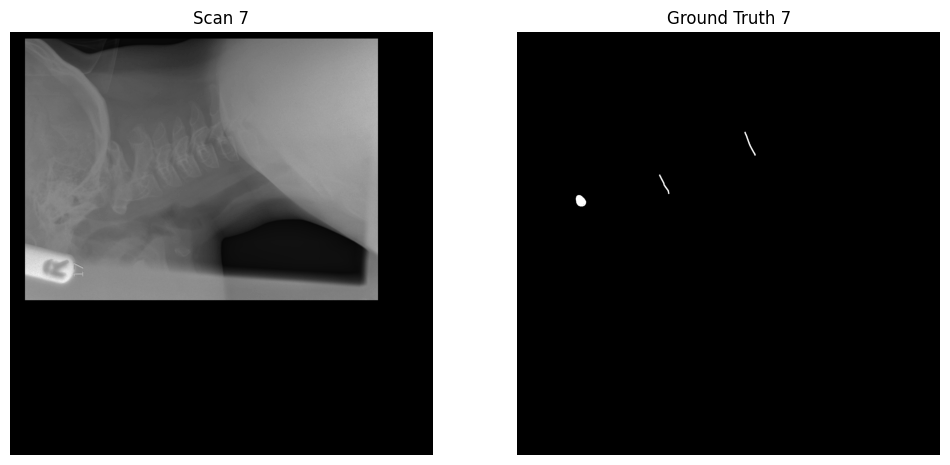

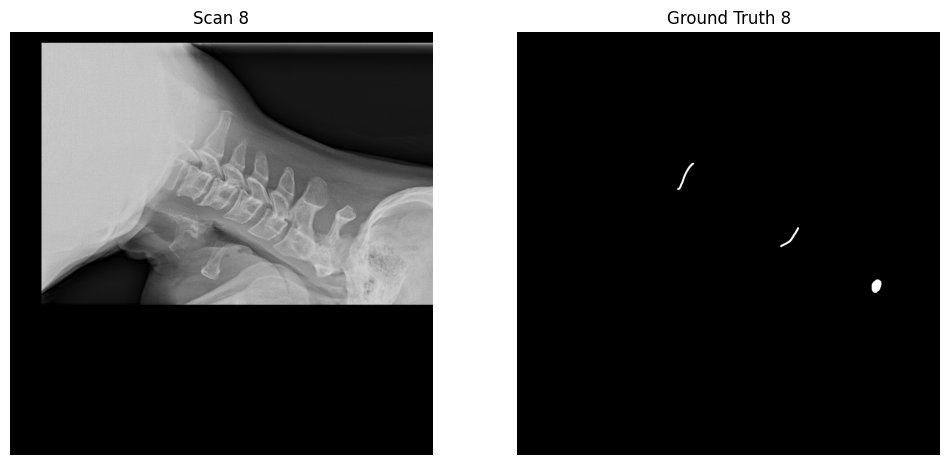

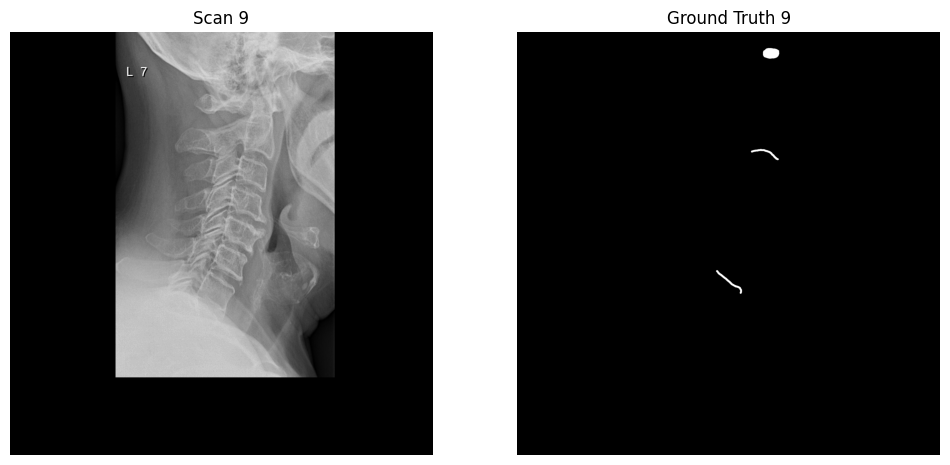

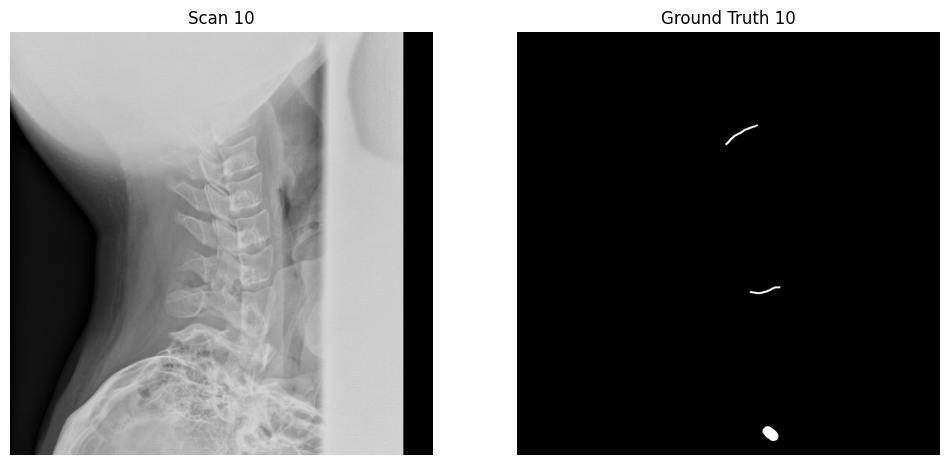

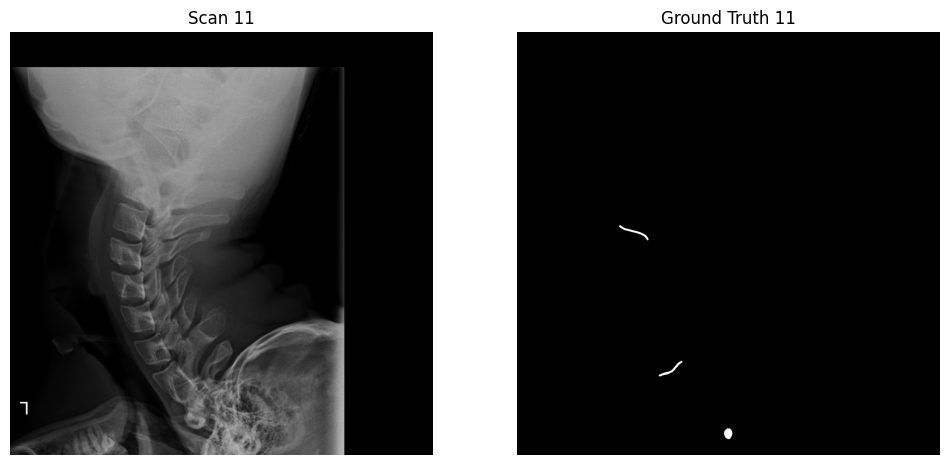

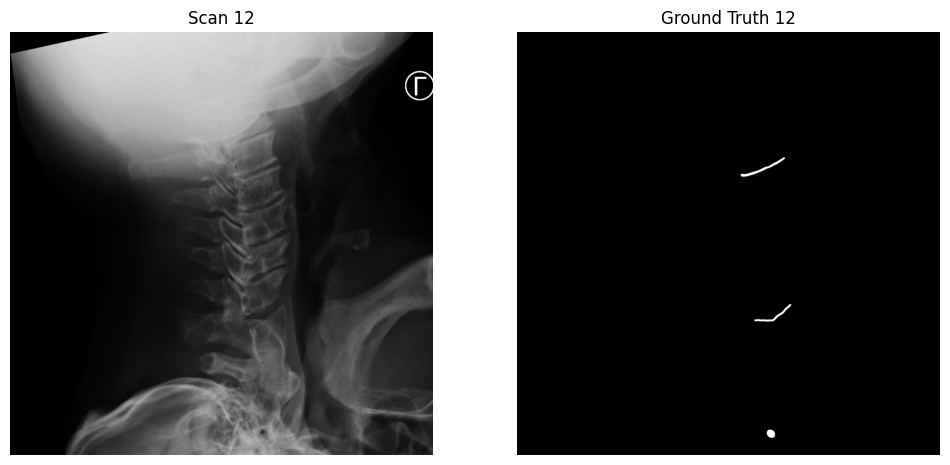

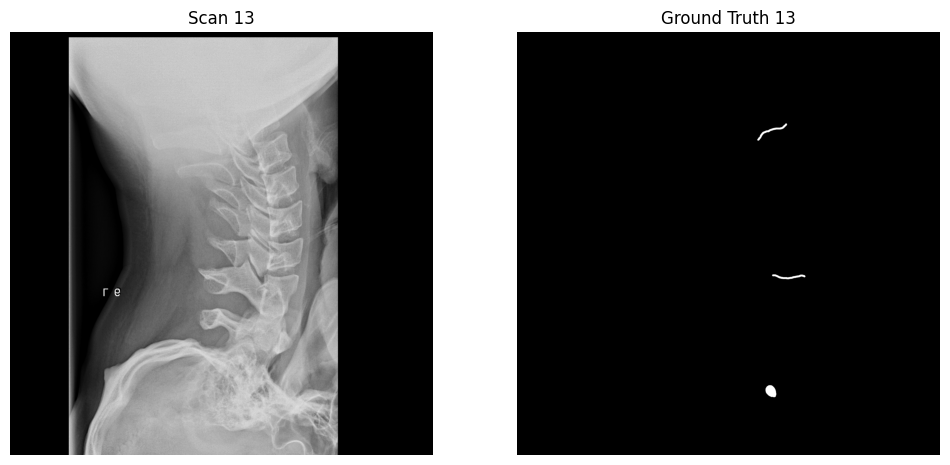

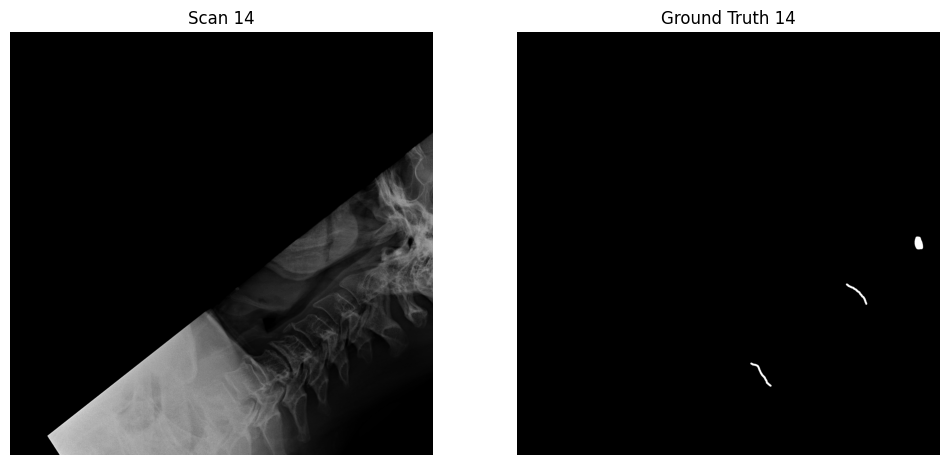

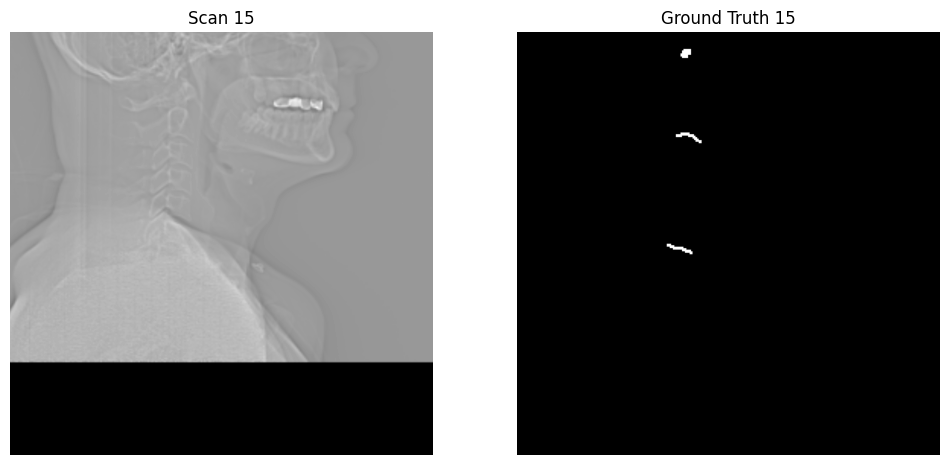

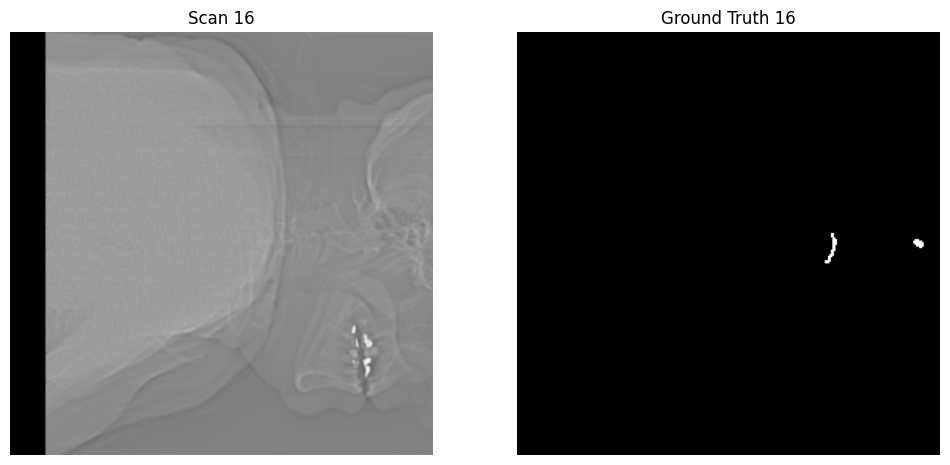

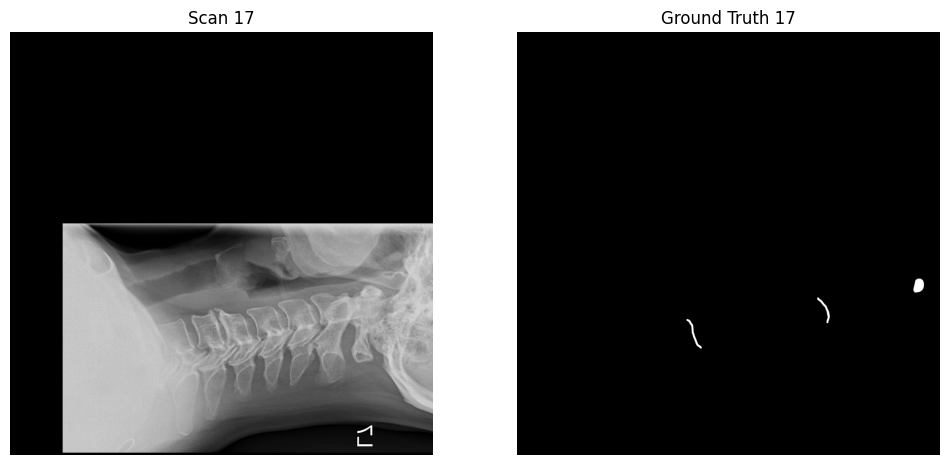

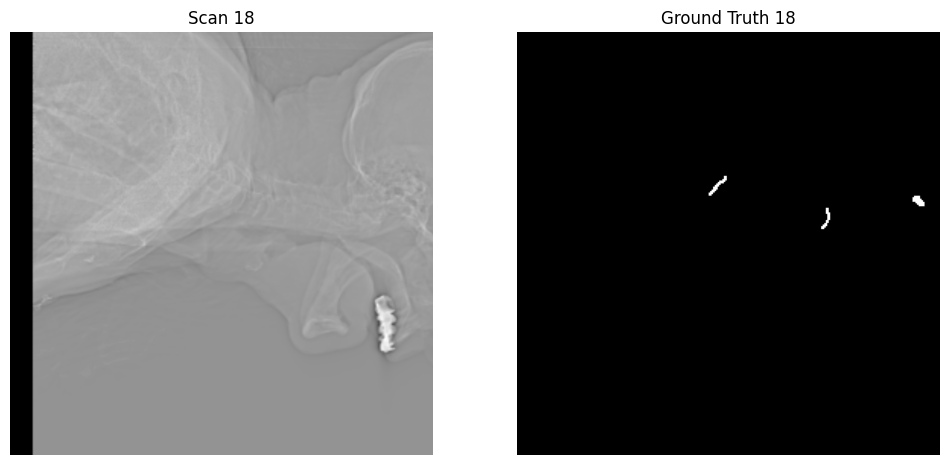

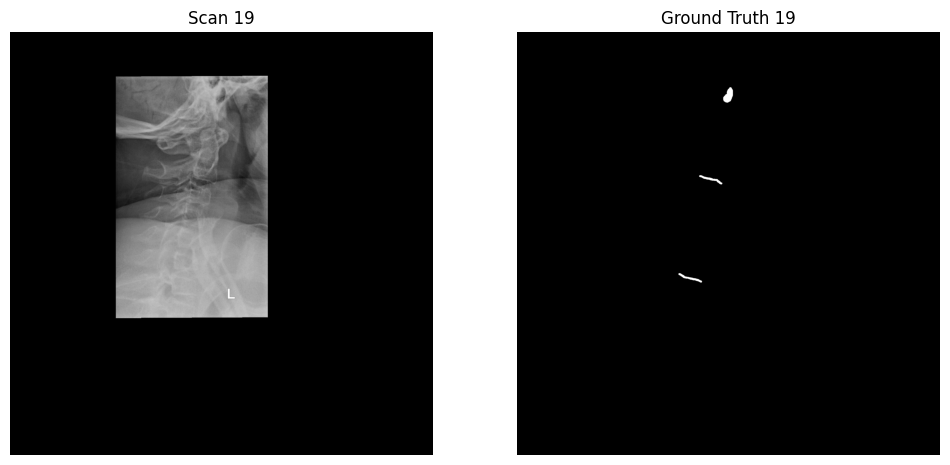

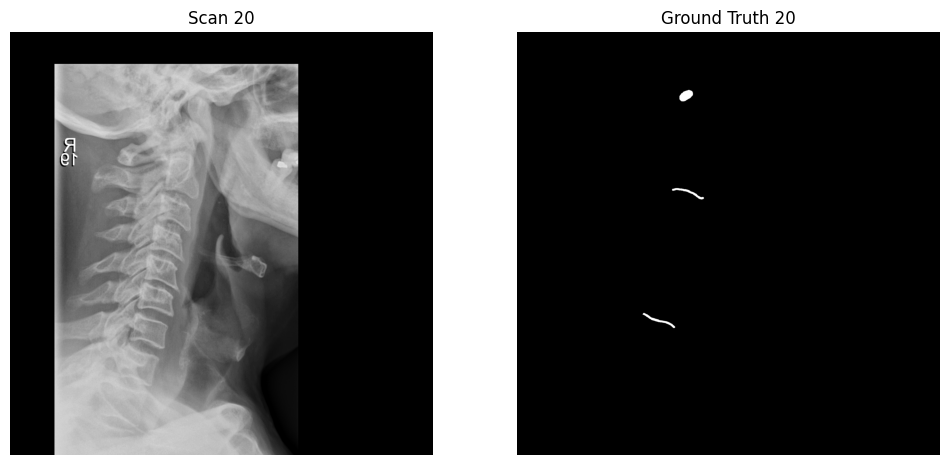

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have `train_dataset` defined and working
# Get the first batch of images and masks
for img_batch, mask_batch in train_dataset.take(1):
    # Convert to numpy arrays for easier handling
    img_batch = img_batch.numpy()
    mask_batch = mask_batch.numpy()
    
    # Plot each image and its corresponding ground truth
    for i in range(batch_size):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Display the image in grayscale (assuming the image has a single channel)
        axs[0].imshow(np.squeeze(img_batch[i]), cmap="gray")
        axs[0].set_title(f"Scan {i+1}")
        axs[0].axis("off")

        # Display the binary ground truth mask
        axs[1].imshow(np.squeeze(mask_batch[i]), cmap="gray")
        axs[1].set_title(f"Ground Truth {i+1}")
        axs[1].axis("off")

        plt.show()


ALL LOOKS GOOD. NOW, STARTING BUILDING UR MODEL, DEFINE YOUR LOSS FUNCTION, METRICS, and TRAIN!

LOSS FUNCTION

In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K

def tversky_loss(y_true, y_pred, alpha=0.23, beta=0.99, smooth=1):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_pos = K.sum(y_true * y_pred)
    false_neg = K.sum(y_true * (1 - y_pred))
    false_pos = K.sum((1 - y_true) * y_pred)
    tversky_index = (true_pos + smooth) / (true_pos + alpha * false_pos + beta * false_neg + smooth)
    return 1 - tversky_index

METRICS

In [14]:
#METRICS
# IoU Score Metrics
def iou_score(y_true, y_pred):
    smoothing_factor = 1
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + smoothing_factor) / (union + smoothing_factor), axis=0)
    return iou

def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    
    intersection = K.sum(flat_y_true * flat_y_pred)
    union = K.sum(flat_y_true) + K.sum(flat_y_pred)
    
    dice = (2. * intersection + smoothing_factor) / (union + smoothing_factor)
    return dice

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Activation, BatchNormalization, add, multiply, UpSampling2D, Lambda
from tensorflow.keras.models import Model
import keras.backend as K

def expend_as(tensor, rep, name):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep}, name='psi_up' + name)(tensor)
    return my_repeat

# Define the 2D attention gating block
def AttnGatingBlock(x, g, inter_shape, name):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl' + name)(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same', name='g_up' + name)(phi_g)

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, (1, 1), padding='same', name='psi' + name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)

    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = Conv2D(shape_x[3], (1, 1), padding='same')(upsample_psi)

    y = multiply([upsample_psi, x], name='q_attn' + name)

    result = Conv2D(shape_x[3], (1, 1), padding='same', name='q_attn_conv' + name)(y)
    result_bn = BatchNormalization(name='q_attn_bn' + name)(result)
    return result_bn

# Define the 2D U-Net convolutional block with residual connections
def UnetConv2D(input, outdim, is_batchnorm, num_conv_layers, name):
    x = input
    for i in range(num_conv_layers):
        x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer='he_normal', padding="same", name=f'{name}_{i+1}')(x)
        if is_batchnorm:
            x = BatchNormalization(name=f'{name}_{i+1}_bn')(x)
        x = Activation('relu', name=f'{name}_{i+1}_relu')(x)
    return x

# Define the 2D gating signal
def UnetGatingSignal(input, is_batchnorm, name):
    shape = K.int_shape(input)
    x = Conv2D(shape[3], (1, 1), strides=(1, 1), padding="same", kernel_initializer='he_normal', name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name=name + '_act')(x)
    return x

# Define the 2D U-Net with attention gates and residual connections
def attn_unet(opt, input_size, lossfxn, metrics, n_classes):
    inputs = Input(shape=input_size)
    
    # Contracting path
    conv1 = UnetConv2D(inputs, 16, is_batchnorm=True, num_conv_layers=2, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = UnetConv2D(pool1, 32, is_batchnorm=True, num_conv_layers=3, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 64, is_batchnorm=True, num_conv_layers=3, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 128, is_batchnorm=True, num_conv_layers=3, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    center = UnetConv2D(pool4, 256, is_batchnorm=True, num_conv_layers=3, name='center')
    
    # Expanding path with attention gates
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    up1 = concatenate([Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(center), conv4], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 128, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up2, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 64, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(up2), attn3], name='up3')

    g4 = UnetGatingSignal(up3, is_batchnorm=True, name='g4')
    attn4 = AttnGatingBlock(conv1, g4, 32, '_4')
    up4 = concatenate([Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(up3), attn4], name='up4')
    
    # Output layer with softmax activation for multiclass classification
    out = Conv2D(n_classes, (1, 1), activation='sigmoid', kernel_initializer='he_normal', name='final')(up4)
    
    model = Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=opt, loss=lossfxn, metrics=metrics)
    return model

In [16]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

def print_gpu_utilization():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    print(gpu_info)

def print_model_device_placement(model):
    # Check if GPU is available
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if not physical_devices:
        print("GPU is not available")
        return
    
    print("GPU is available")

# Initialize strategy for distributed training
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.NcclAllReduce())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    initial_learning_rate = 0.0001  # Set your desired initial learning rate
    
    optim = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    
    # Create the model using Focal Tversky Loss
    model = attn_unet(
        optim, 
        (2000, 2000, 1), 
        tversky_loss,  # Pass tversky_loss directly
        [iou_score, dice_coefficient], 
        n_classes
    )
    
    # Print model summary
    model.summary()
    
    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        verbose=1,
        min_lr=1e-6
    )
    
    # Define ModelCheckpoint to save the best model
    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    
    # Define TensorBoard callback
    tensorboard = TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        write_graph=True,
        write_images=True
    )
    
    # Print GPU utilization and model device placement
    print_gpu_utilization()
    print_model_device_placement(model)

    # Add TensorBoard to the list of callbacks
    callbacks = [reduce_lr, checkpoint, tensorboard]


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localh

In [15]:
epochs = 40

# Define ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath='Models/Natalia3E{epoch:02d}.keras',  # Path where to save the model, including epoch
    save_best_only=False,  # Save the model after every epoch
    monitor='val_loss',  # Still monitor validation loss to log improvements
    mode='min',  # The smaller the monitored quantity, the better
    verbose=1  # Log a message after every epoch
)

# Define the whole list of callbacks
callbacks = [reduce_lr, checkpoint, tensorboard, model_checkpoint_callback]

# Fit the model using the custom generator for training data
history = model.fit(
    train_dataset,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_dataset,
    validation_steps=num_val_samples // batch_size,
    callbacks=callbacks
)

2024-12-21 13:56:11.478662: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/40
INFO:tensorflow:batch_all_reduce: 120 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 120 all-reduces with algorithm = nccl, num_packs = 1


2024-12-21 13:56:22.331305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-12-21 13:56:22.337673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-12-21 13:56:22.560370: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-21 13:56:37.490540: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-12-21 13:56:38.503113: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-21 13:56:38.503258: W tensor

635/635 [==============================] - ETA: 0s - loss: 0.7672 - iou_score: 0.1184 - dice_coefficient: 0.2122
Epoch 1: val_loss improved from inf to 0.78584, saving model to best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: saving model to Models/Natalia3E01.keras
635/635 [==============================] - 1080s 2s/step - loss: 0.7672 - iou_score: 0.1184 - dice_coefficient: 0.2122 - val_loss: 0.7858 - val_iou_score: 0.1555 - val_dice_coefficient: 0.2832 - lr: 1.0000e-04
Epoch 2/40
635/635 [==============================] - ETA: 0s - loss: 0.6109 - iou_score: 0.2140 - dice_coefficient: 0.3550
Epoch 2: val_loss improved from 0.78584 to 0.66058, saving model to best_model.h5

Epoch 2: saving model to Models/Natalia3E02.keras
635/635 [==============================] - 1031s 2s/step - loss: 0.6109 - iou_score: 0.2140 - dice_coefficient: 0.3550 - val_loss: 0.6606 - val_iou_score: 0.2291 - val_dice_coefficient: 0.3862 - lr: 1.0000e-04
Epoch 3/40
635/635 [==============================] - ETA: 0s - loss: 0.5201 - iou_score: 0.2784 - dice_coefficient: 0.4351
Epoch 3: val_loss improved from 0.66058 to 0.55157, saving model to best_model.h5

Epoch 3: saving model to Models/Natalia3E03.keras
635/635 [======

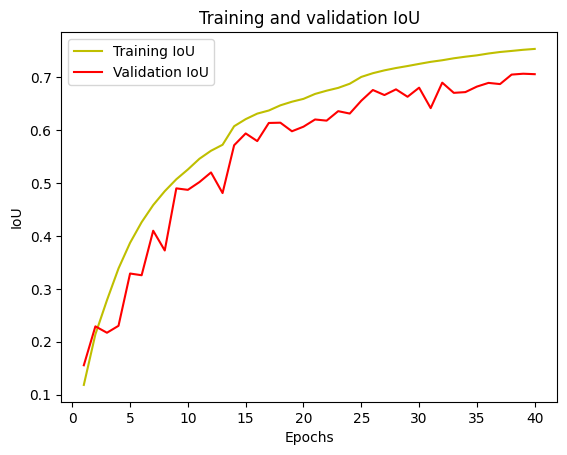

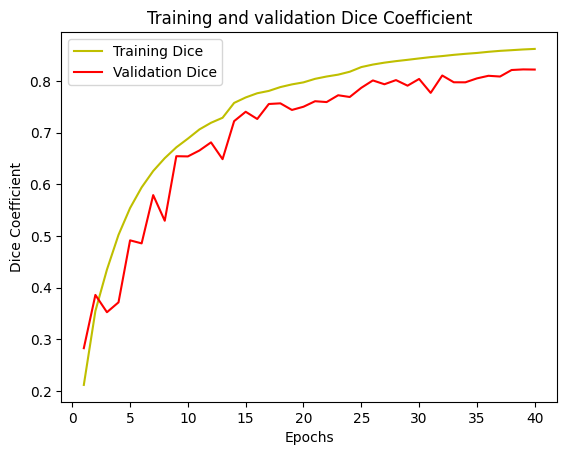

In [16]:
import matplotlib.pyplot as plt

# Generate the list of epochs
epochs = range(1, len(history.history['iou_score']) + 1)

# Plot Training and Validation IoU
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# Plot Training and Validation Dice Coefficient
dice = history.history['dice_coefficient']
val_dice = history.history['val_dice_coefficient']
plt.plot(epochs, dice, 'y', label='Training Dice')
plt.plot(epochs, val_dice, 'r', label='Validation Dice')
plt.title('Training and validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [17]:
#Save model for future use
model.save('/workspace/FinalBoss40.keras')

Load in the model if you have just opened this kernel without training it

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Define the dice_coefficient function
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    
    intersection = K.sum(flat_y_true * flat_y_pred)
    union = K.sum(flat_y_true) + K.sum(flat_y_pred)
    
    dice = (2. * intersection + smoothing_factor) / (union + smoothing_factor)
    return dice

# Other custom functions or losses, like iou_score
def iou_score(y_true, y_pred):
    smoothing_factor = 1
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smoothing_factor) / (union + smoothing_factor), axis=0)
    return iou

from keras.saving import register_keras_serializable
from tensorflow.keras import backend as K

@register_keras_serializable()
def tversky_loss(y_true, y_pred, alpha=0.23, beta=0.99, smooth=1):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_pos = K.sum(y_true * y_pred)
    false_neg = K.sum(y_true * (1 - y_pred))
    false_pos = K.sum((1 - y_true) * y_pred)
    tversky_index = (true_pos + smooth) / (true_pos + alpha * false_pos + beta * false_neg + smooth)
    return 1 - tversky_index

model = load_model(
    '/workspace/FinalBoss40.keras',
    custom_objects={
        'dice_coefficient': dice_coefficient,
        'iou_score': iou_score,
        'tversky_loss': tversky_loss
    }
)

In [15]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/3f/a4/d2537f47fd7fcfba966bd806e3ec18e7ee1681056d4b0a9c8d983983e4d5/opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 1.4 MB/s eta 0:00:0000:0100:02m

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [16]:
# Remove the first and last dimensions if they exist (i.e., shape is (1, 2000, 2000, 1))
binary_mask = mask_batch[0]

# Squeeze the first dimension (if it's 1) and then squeeze the last dimension (if it's 1)
if len(binary_mask.shape) == 4 and binary_mask.shape[0] == 1:
    binary_mask = np.squeeze(binary_mask, axis=0)  # Remove the first dimension

if len(binary_mask.shape) == 3 and binary_mask.shape[-1] == 1:
    binary_mask = np.squeeze(binary_mask, axis=-1)  # Remove the last dimension

print(binary_mask.shape)  # Should be (2000, 2000)

(2000, 2000)


In [17]:
import SimpleITK as sitk
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import math

In [18]:
import tensorflow as tf
import glob
import numpy as np

def create_dataset(image_dir, mask_dir, batch_size):
    # Get all image and mask file paths and sort them in order
    image_files = sorted(glob.glob(image_dir))
    mask_files = sorted(glob.glob(mask_dir))

    # Ensure both lists have the same length
    assert len(image_files) == len(mask_files), "Image and mask files lists must be the same length."

    # Create a TensorFlow dataset from the file names
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

    def _parse_function(image_file, mask_file):
        # Load image and mask as float16
        image, mask = tf.numpy_function(preprocess_image_mask, [image_file, mask_file], [tf.float16, tf.float16])
        image.set_shape([2000, 2000, 1])  # Adjusted for 2D shape
        mask.set_shape([2000, 2000, 1])   # Adjusted for 2D shape without one-hot encoding (binary classification)
        return image, mask

    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.repeat()

    return dataset


In [19]:
pip install statsmodels

  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/9d/4f/a96e682f82b675e4a6f3de8ad990587d8b1fde500a630a2aabcaabee11d8/statsmodels-0.14.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas!=2.1.0,>=1.4 from https://files.pythonhosted.org/packages/cd/5f/4dba1d39bb9c38d574a9a22548c540177f78ea47b32f99c0ff2ec499fac5/pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for patsy>=0.5.6 from https://files.pythonhosted.org/packages/87/2b/b50d3d08ea0fc419c183a84210571eba005328efa62b6b98bc28e9ead32a/patsy-1.0.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/11/c3/005fcca25ce078d2cc29fd559379817424e94885510568bc1bc53d7d5846/pytz-2024.2-py2.py3-none-any.whl.metada

DELETE ONCE READY TO SUBMIT TO TOM

Number of test samples: 28
1/1 [==============================] - 0s 27ms/step
Processing file: 1369511.1_aug1_original.nrrd


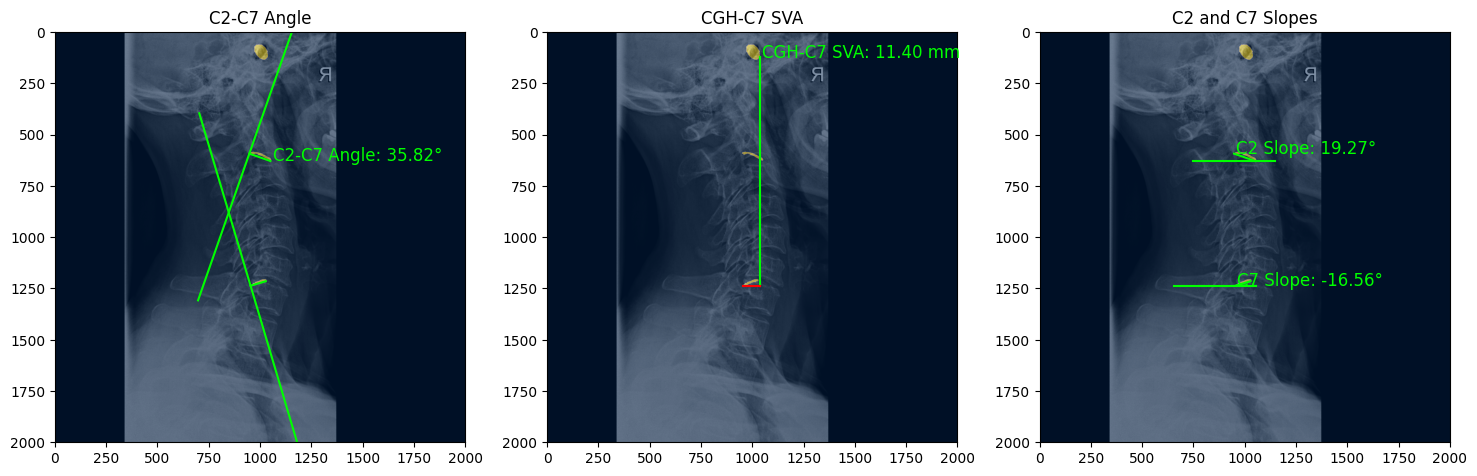

1/1 [==============================] - 0s 26ms/step
Processing file: 1546478.1_aug1_original.nrrd


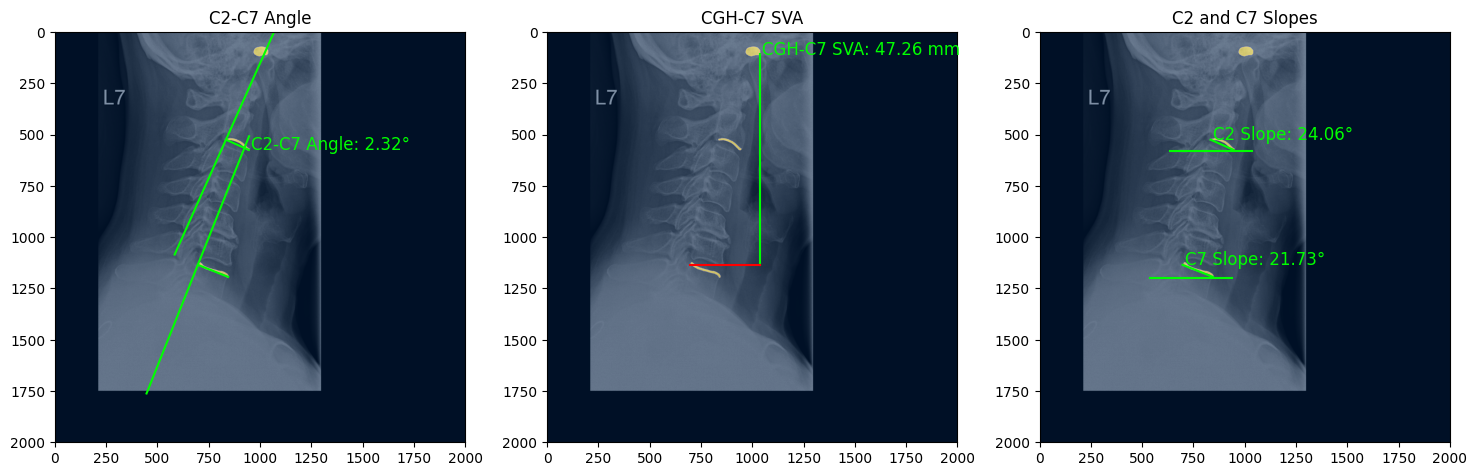

1/1 [==============================] - 0s 28ms/step
Processing file: 1841471.1_aug1_original.nrrd


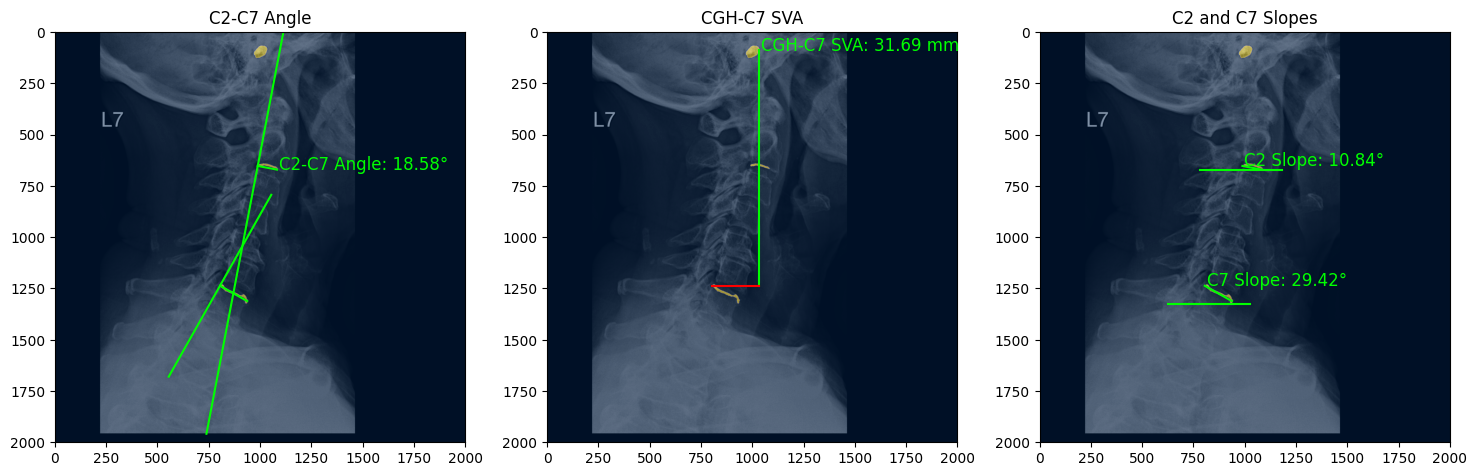

1/1 [==============================] - 0s 67ms/step
Processing file: 2046452.1_aug1_original.nrrd


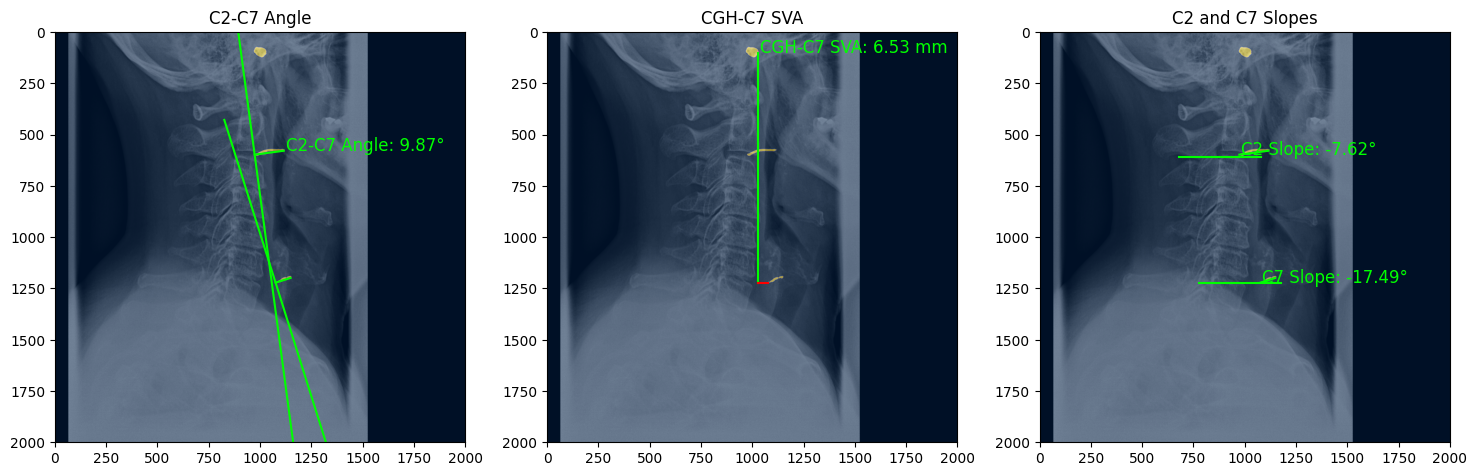

1/1 [==============================] - 0s 25ms/step
Processing file: 2210657.1_aug1_original.nrrd


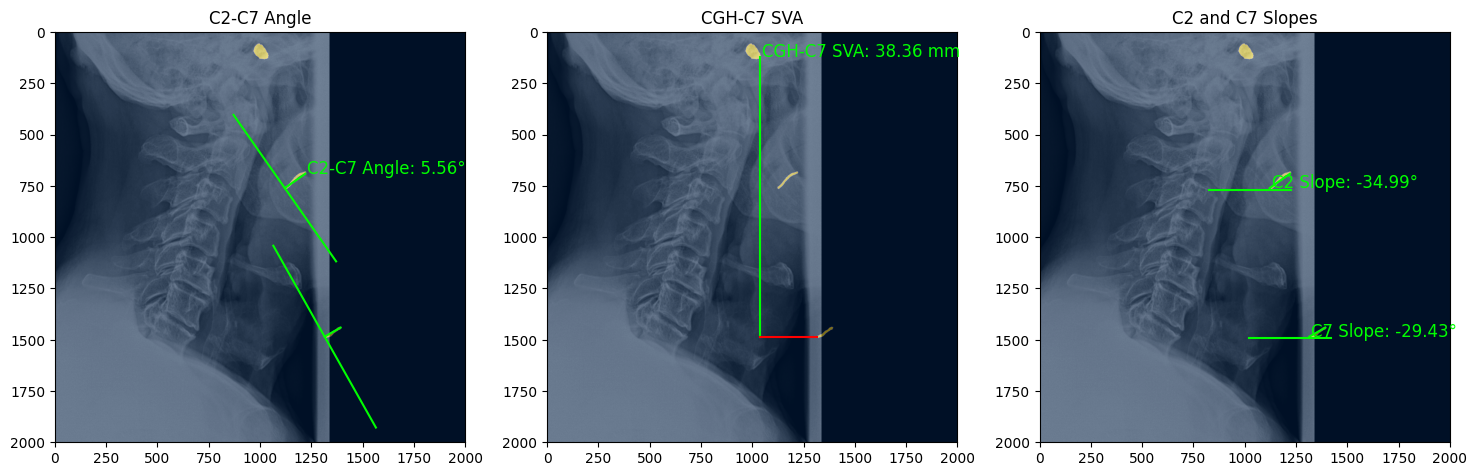

1/1 [==============================] - 0s 26ms/step
Processing file: 617437.1_aug1_original.nrrd


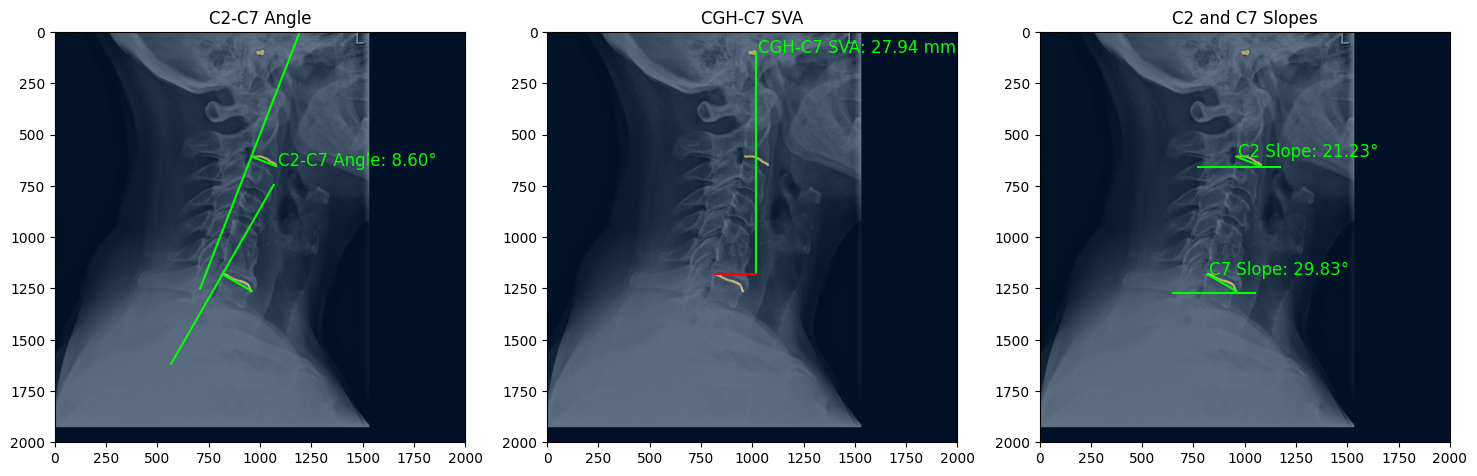

1/1 [==============================] - 0s 25ms/step
Processing file: X_PUM_01_aug1_original.nrrd


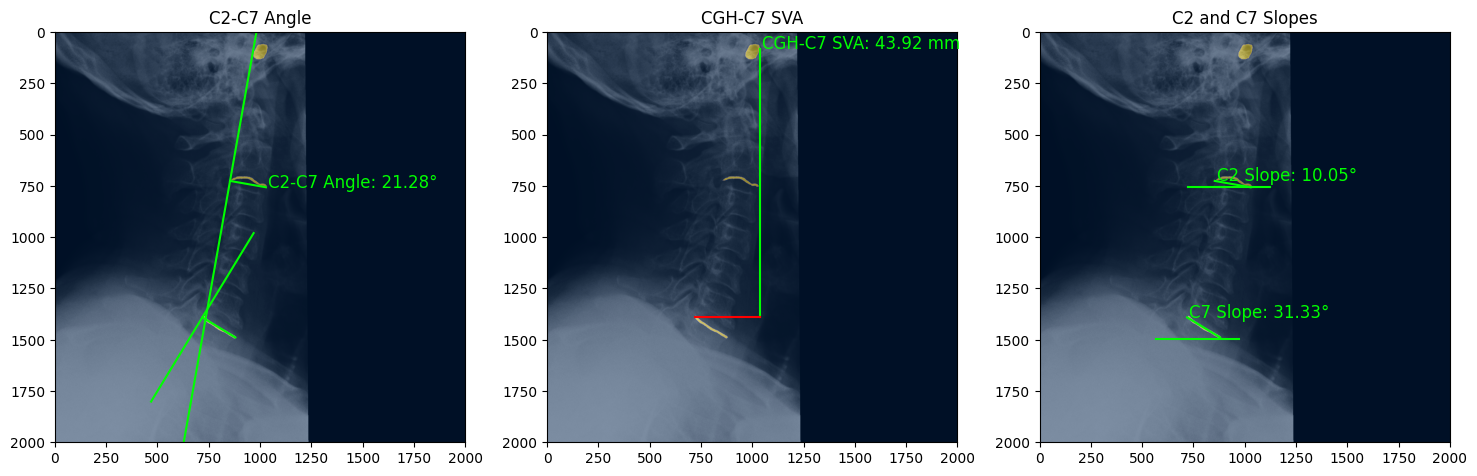

1/1 [==============================] - 0s 23ms/step
Processing file: X_PUM_02_aug1_original.nrrd


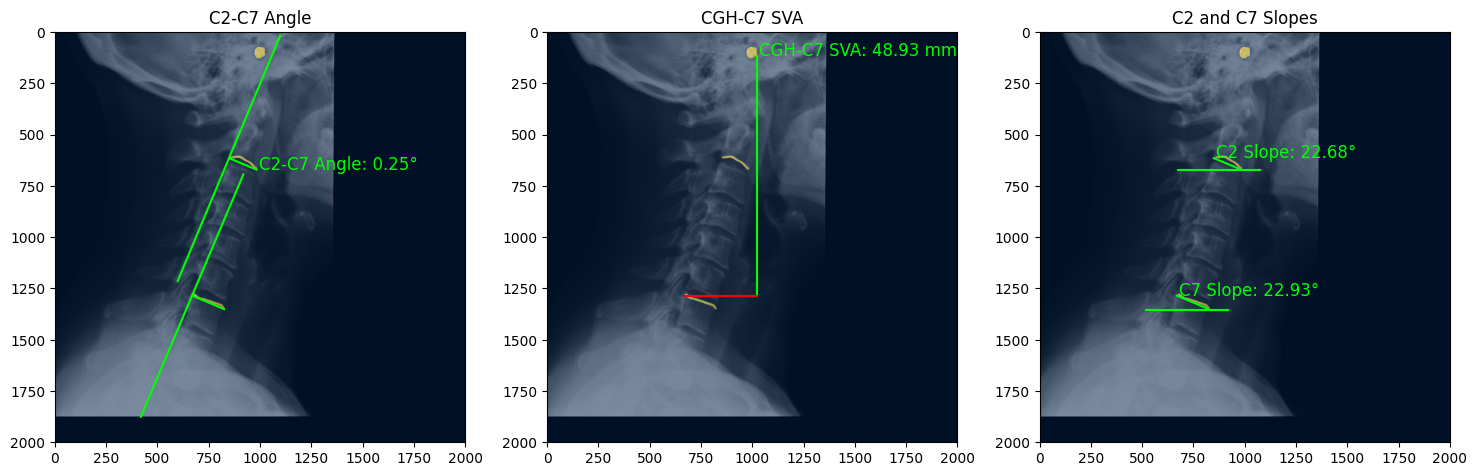

1/1 [==============================] - 0s 26ms/step
Processing file: X_PUM_03_aug2_original.nrrd


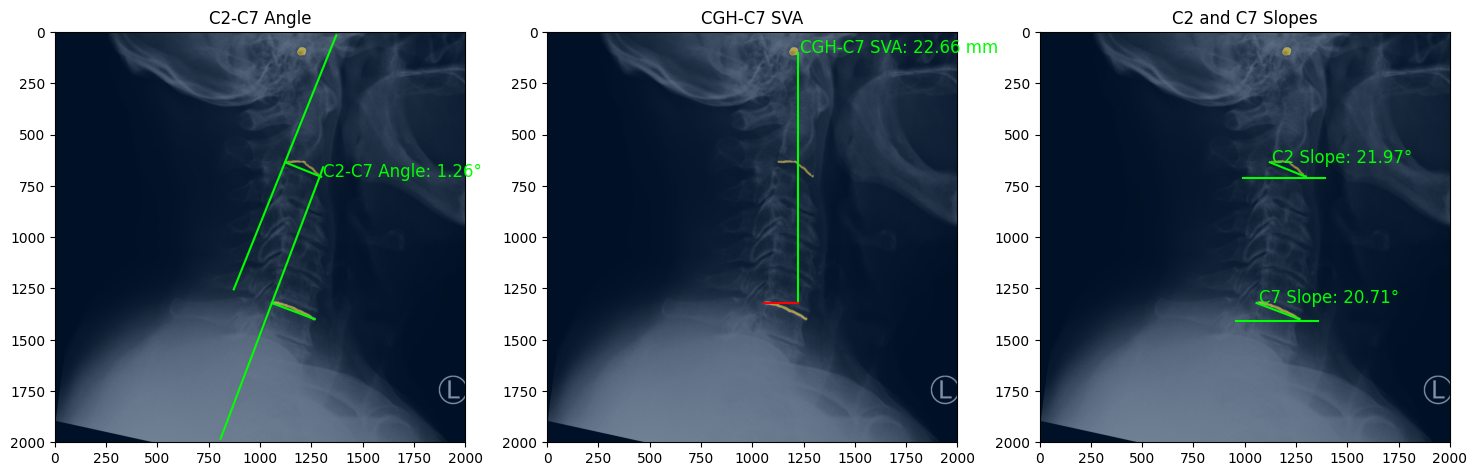

1/1 [==============================] - 0s 24ms/step
Processing file: X_PUM_05_aug1_original.nrrd


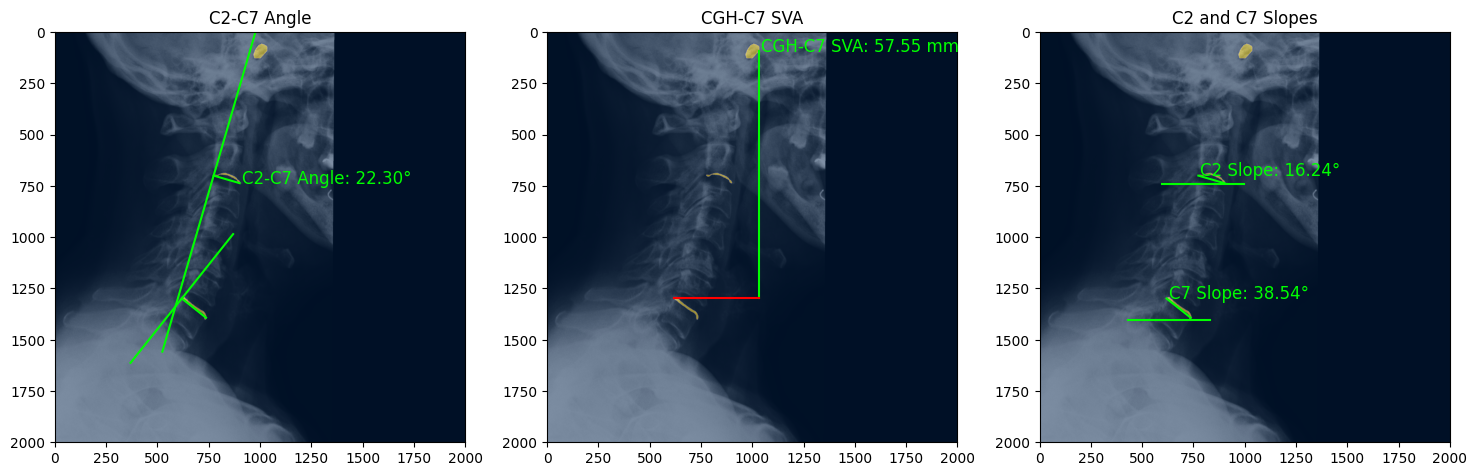

1/1 [==============================] - 0s 23ms/step
Processing file: X_PUM_07_aug2_original.nrrd


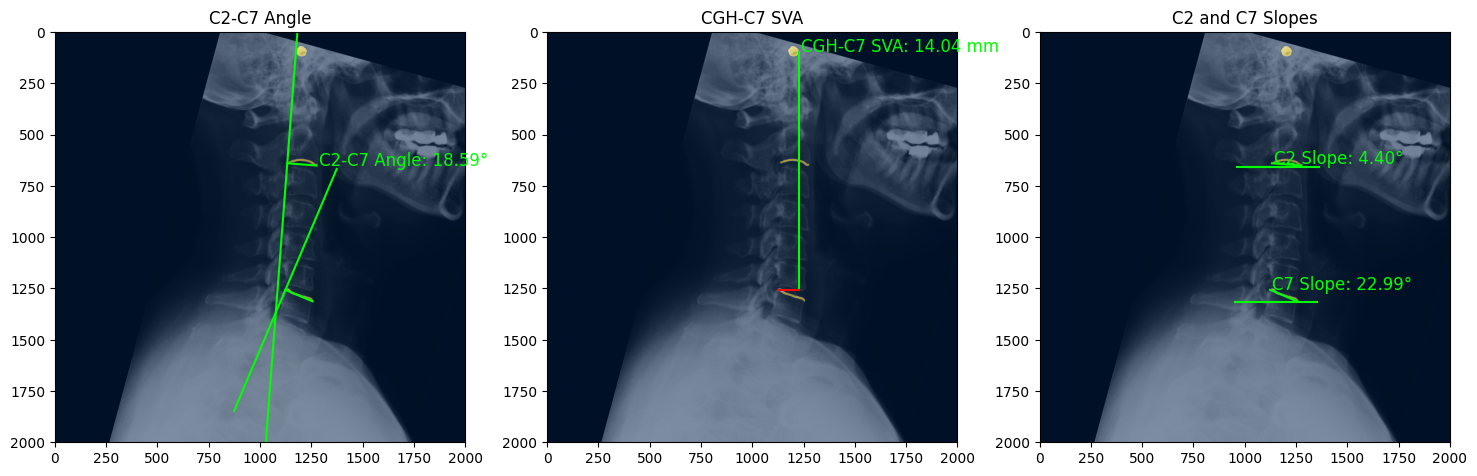

1/1 [==============================] - 0s 24ms/step
Processing file: X_PUM_09_aug1_original.nrrd


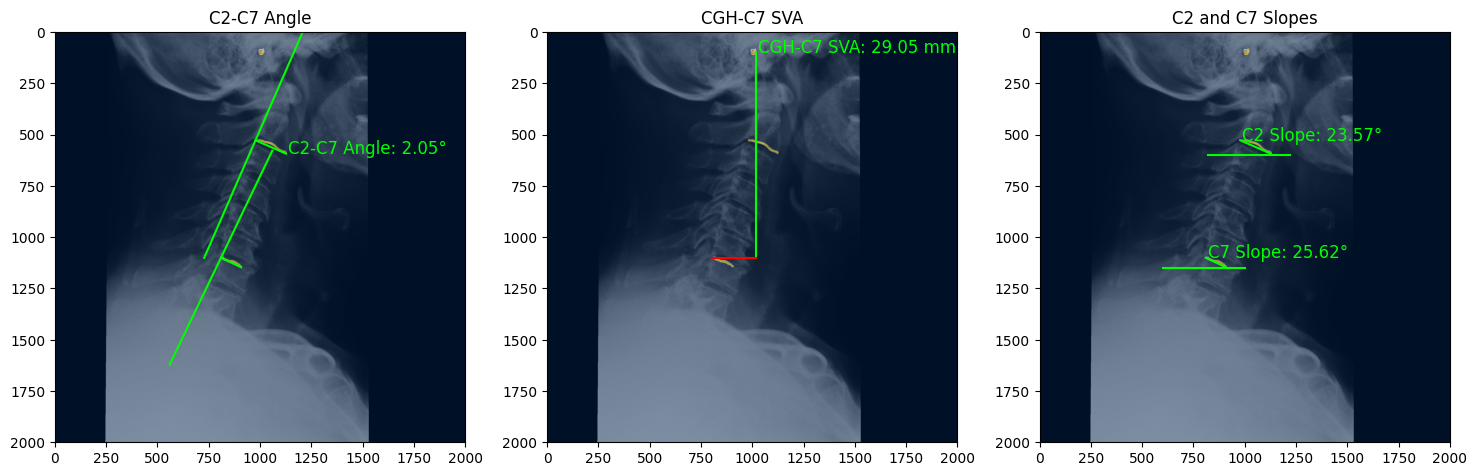

1/1 [==============================] - 0s 62ms/step
Processing file: X_PUM_10_aug1_original.nrrd


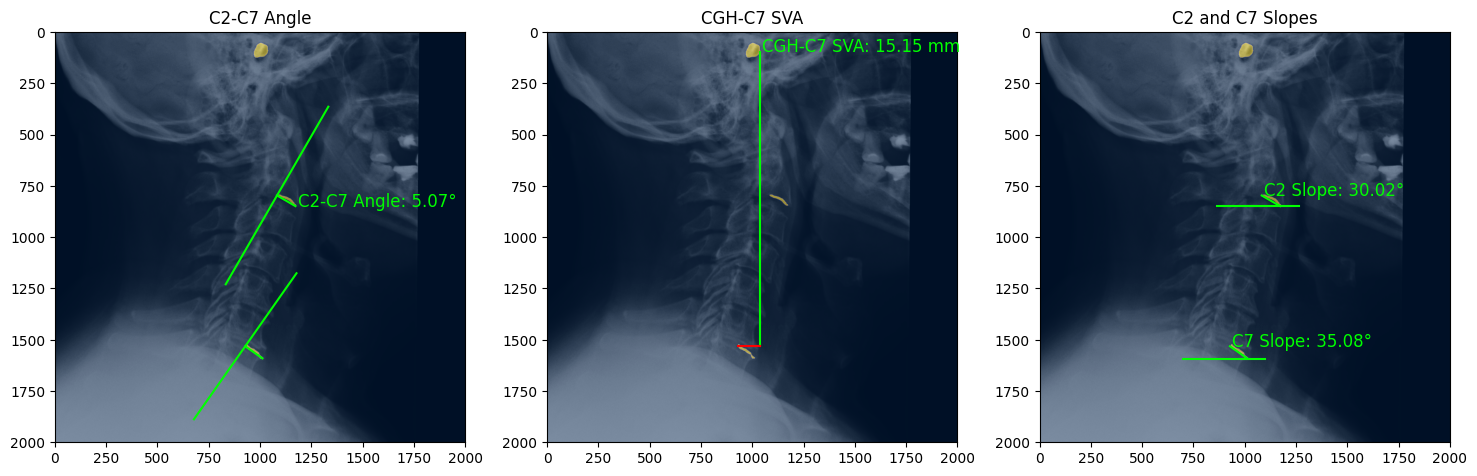

1/1 [==============================] - 0s 24ms/step
Processing file: X_PUM_11_aug1_original.nrrd


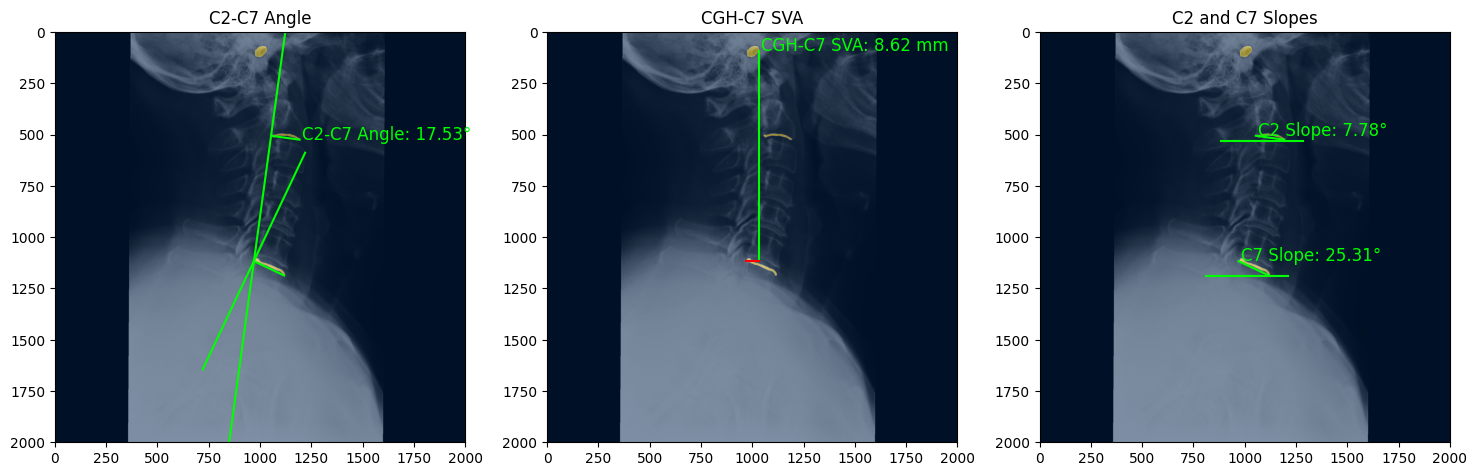

1/1 [==============================] - 0s 24ms/step
Processing file: X_PUM_12_aug1_original.nrrd


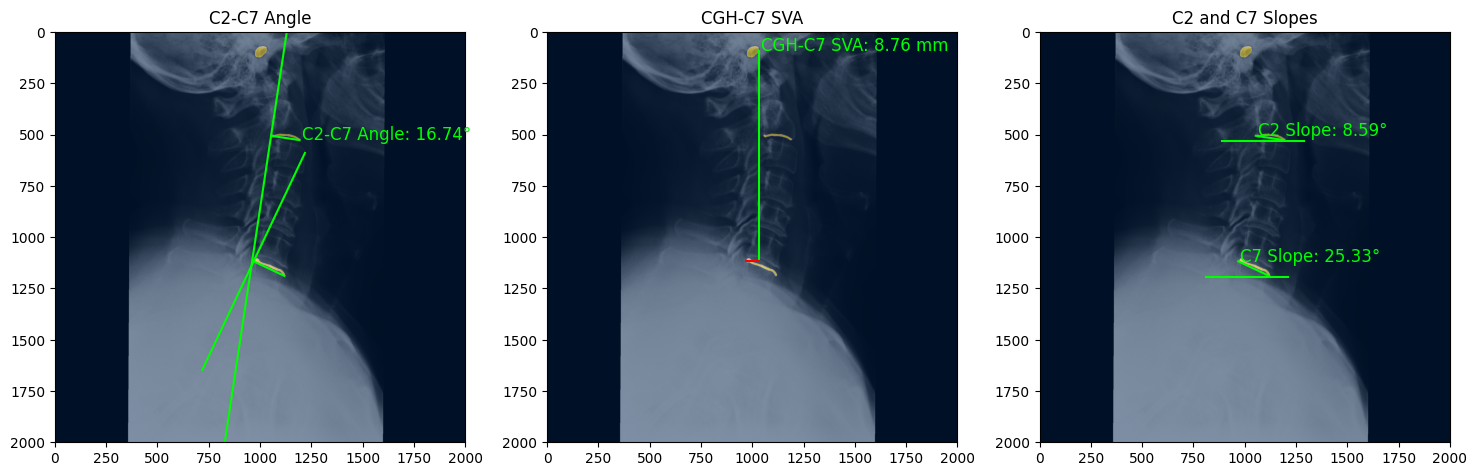

1/1 [==============================] - 0s 23ms/step
Processing file: X_PUM_13_aug1_original.nrrd


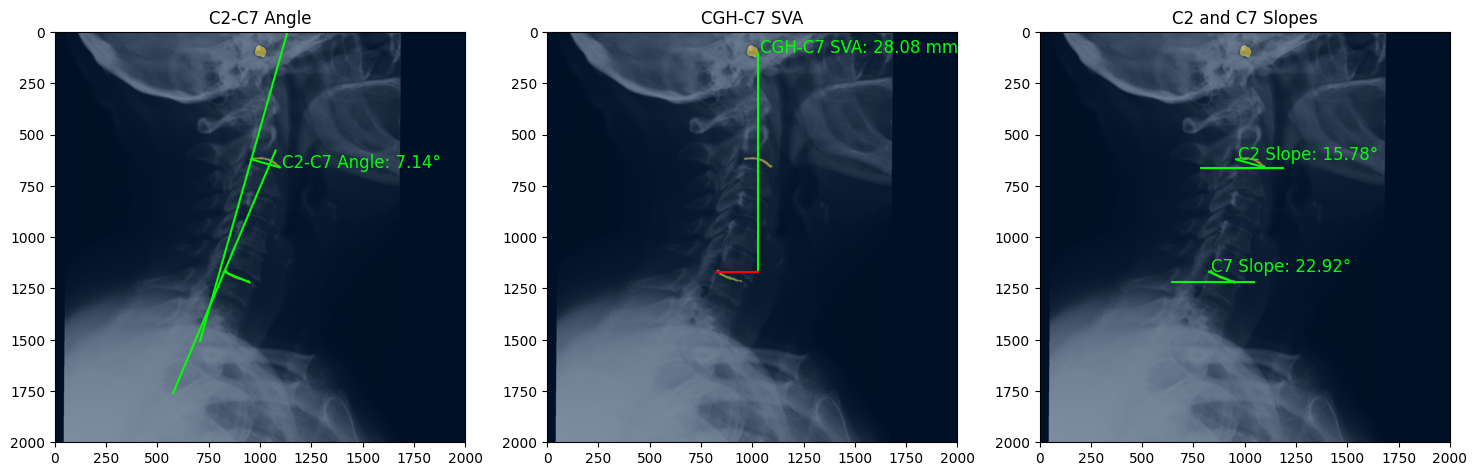

1/1 [==============================] - 0s 26ms/step
Processing file: X_PUM_14_aug1_original.nrrd


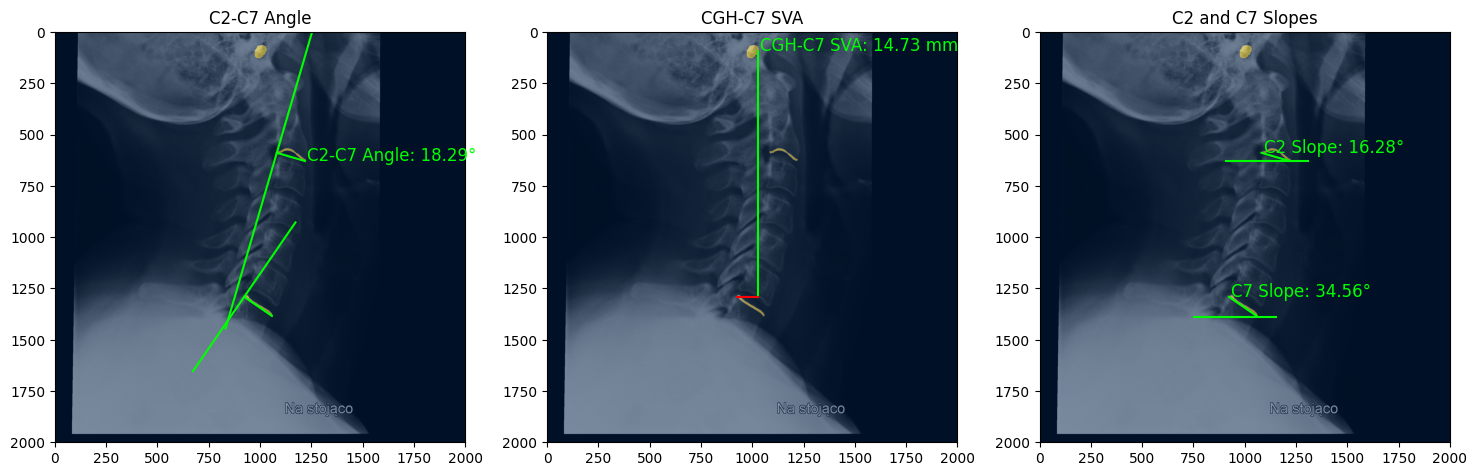

1/1 [==============================] - 0s 24ms/step
Processing file: X_PUM_15_aug2_original.nrrd


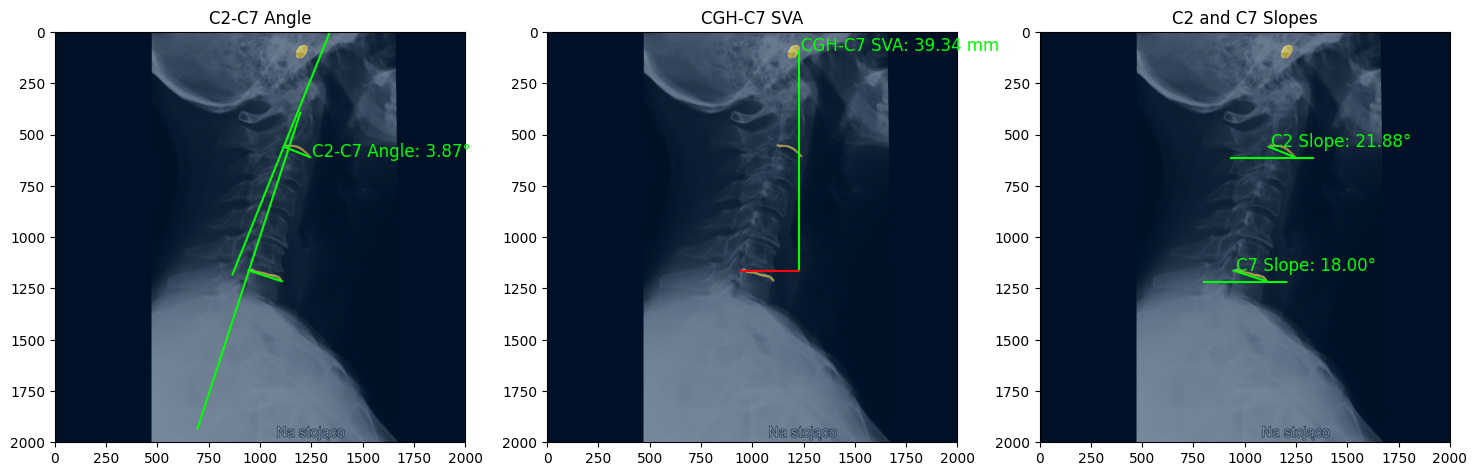

1/1 [==============================] - 0s 24ms/step
Processing file: X_PUM_17_aug1_original.nrrd


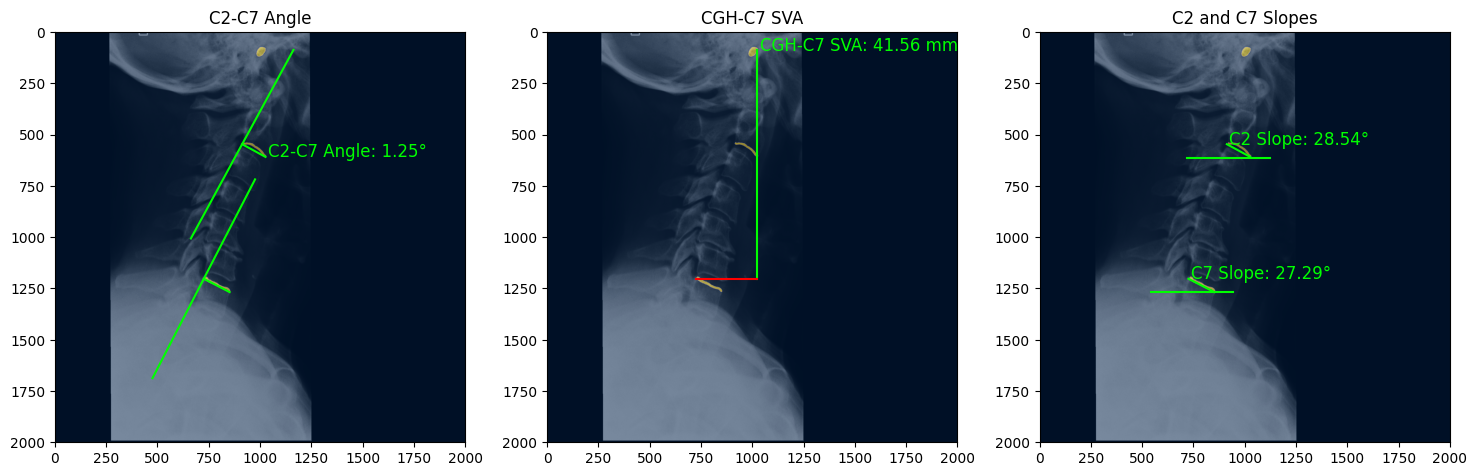

1/1 [==============================] - 0s 25ms/step
Processing file: X_PUM_18_aug1_original.nrrd


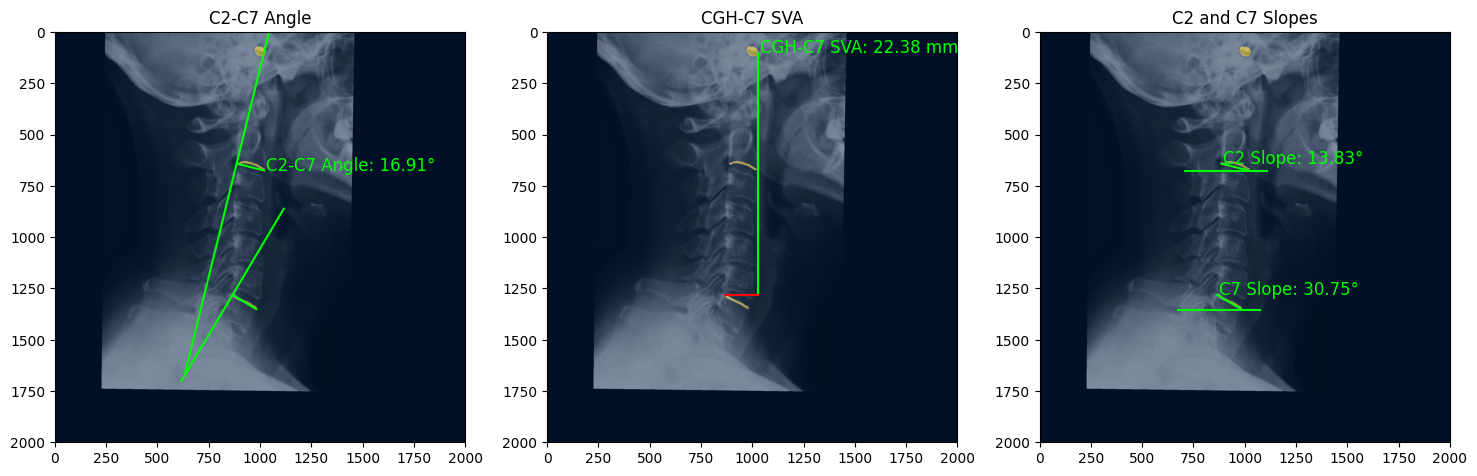

1/1 [==============================] - 0s 24ms/step
Processing file: X_PUM_19_aug1_original.nrrd


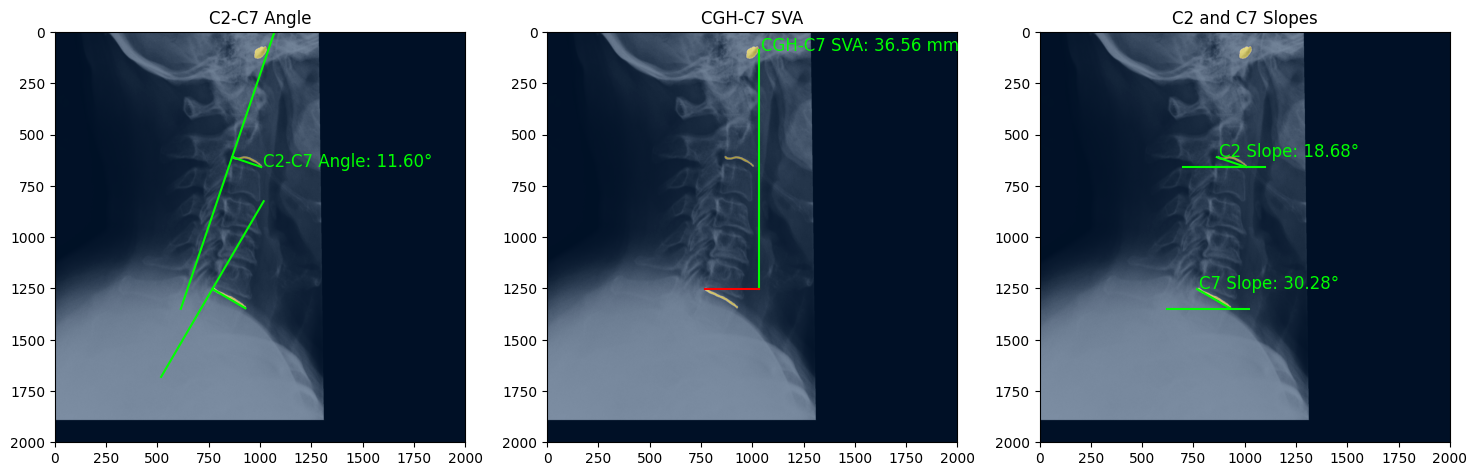

1/1 [==============================] - 0s 23ms/step
Processing file: X_PUM_20_aug1_original.nrrd


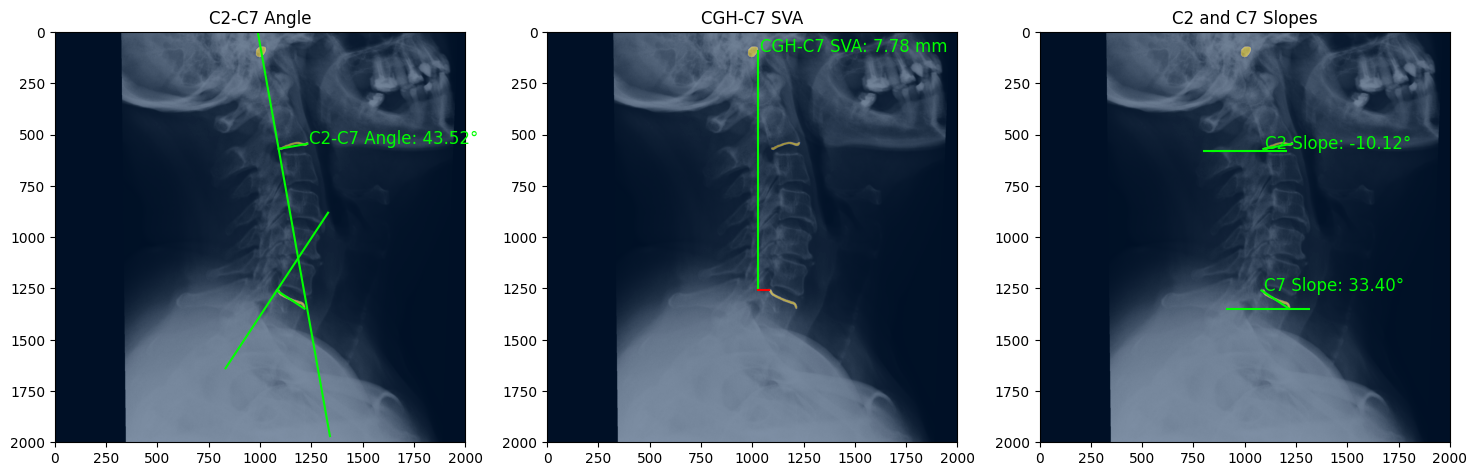

1/1 [==============================] - 0s 26ms/step
Processing file: X_PUM_21_aug1_original.nrrd


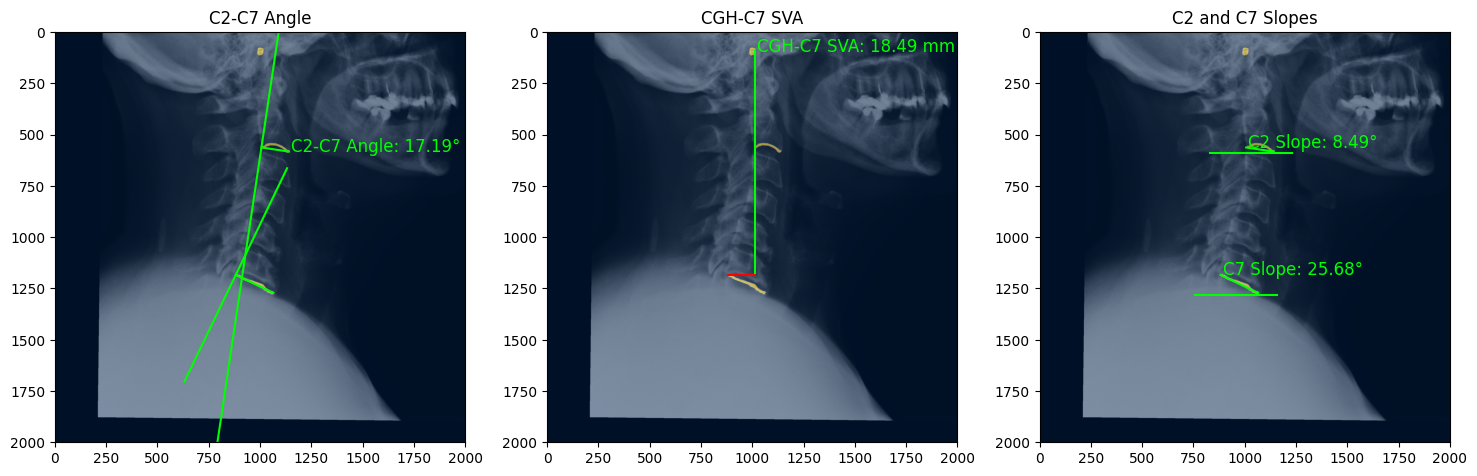

1/1 [==============================] - 0s 27ms/step
Processing file: X_PUM_22_aug1_original.nrrd


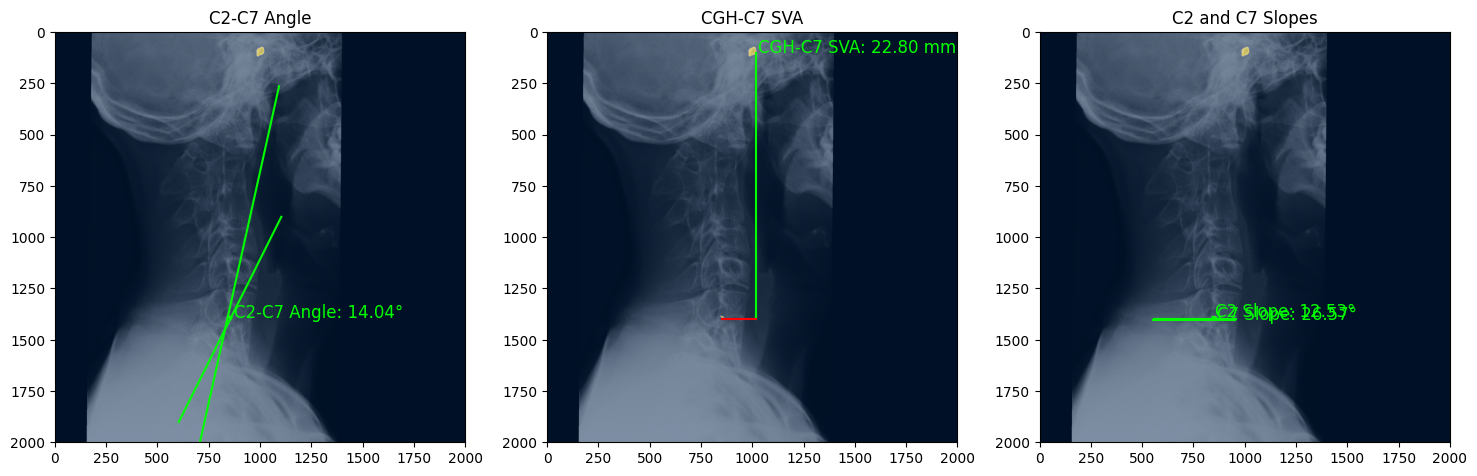

1/1 [==============================] - 0s 24ms/step
Processing file: X_PUM_23_aug1_original.nrrd


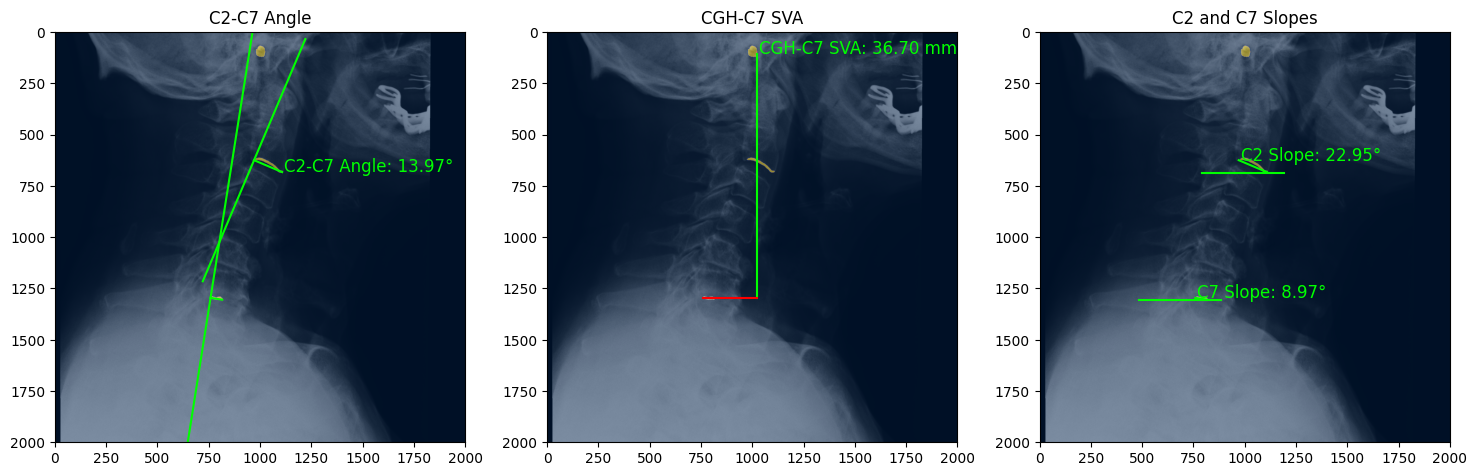

1/1 [==============================] - 0s 26ms/step
Processing file: flipped_1369511.1_aug1_original.nrrd


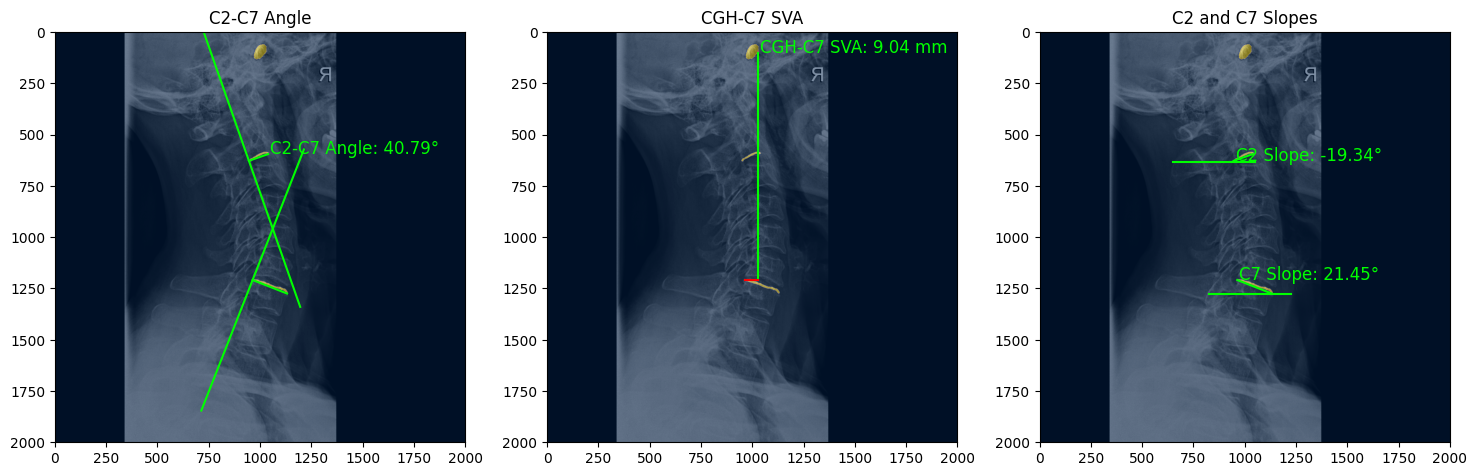

1/1 [==============================] - 0s 24ms/step
Processing file: flipped_2046452.1_aug1_original.nrrd


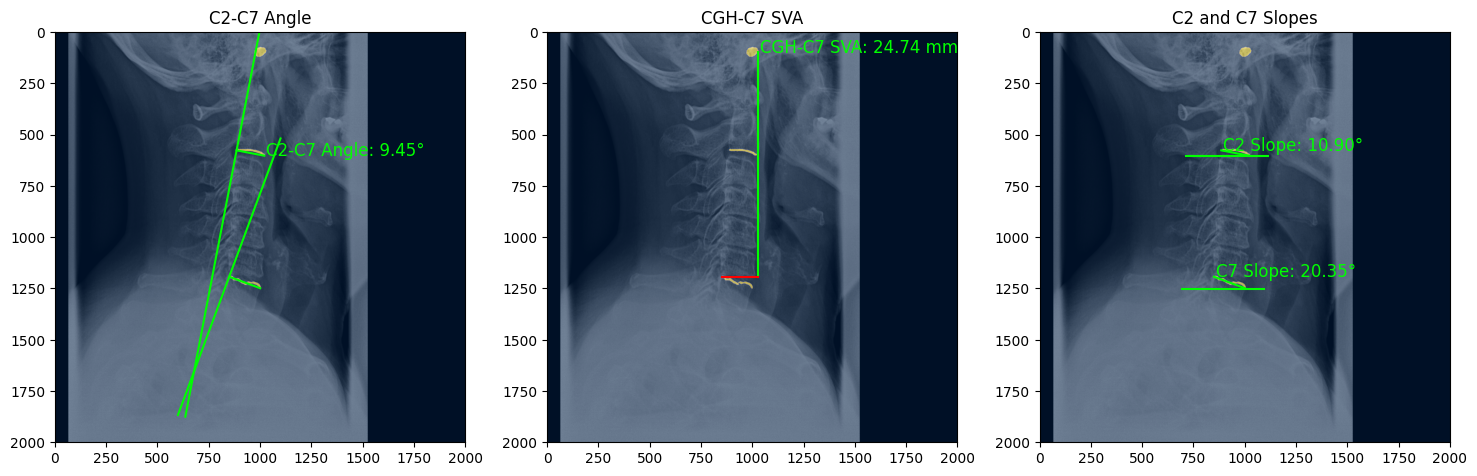

1/1 [==============================] - 0s 24ms/step
Processing file: flipped_2210657.1_aug1_original.nrrd


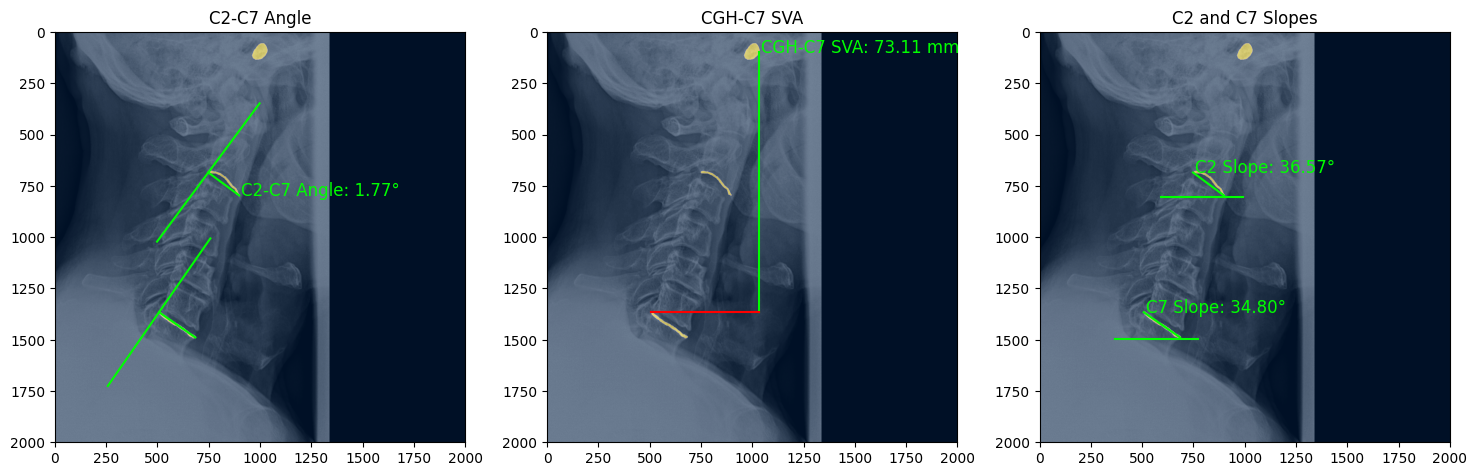

In [48]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2  # Using OpenCV for connected components
import math

# Function to calculate the number of samples in the test dataset
def calculate_num_samples(image_dir, mask_dir):
    file_pairs = list(zip(sorted(glob.glob(image_dir)), sorted(glob.glob(mask_dir))))
    return len(file_pairs)

# Directories for test set
test_img_dir = "/workspace/testxray/*.nrrd"
test_mask_dir = "/workspace/testgt/*.nrrd"

# Calculate number of test samples
num_test_samples = calculate_num_samples(test_img_dir, test_mask_dir)

# Set batch size to 1
batch_size = 1

# Create test dataset
test_dataset = create_dataset(test_img_dir, test_mask_dir, batch_size)

# Print the number of test samples
print(f"Number of test samples: {num_test_samples}")

# Function to calculate distances and angles (already provided)
def get_left_right_corners(contour):
    """Get the left-most and right-most points of a contour."""
    left_corner = tuple(contour[contour[:, :, 0].argmin()][0])
    right_corner = tuple(contour[contour[:, :, 0].argmax()][0])
    return left_corner, right_corner

def calculate_distances_and_angles(binary_mask):
    """
    This function calculates C2-C7 angle, CGH-C7 SVA, and C2 and C7 slopes.
    """
    # Ensure mask is binary
    binary_mask = (binary_mask > 0).astype(np.uint8)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    
    # Ensure we have exactly 3 clusters (acoustic meatus, C2, and C7)
    if num_labels != 4:  # We expect 4 labels (1 background + 3 objects)
        raise ValueError(f"Expected 3 segmented regions, but found {num_labels - 1}")
    
    # Extract relevant clusters based on centroid positions (sorting vertically)
    components = sorted([(i, centroids[i]) for i in range(1, num_labels)], key=lambda x: x[1][1])

    # Assign the components
    acoustic_meatus_label = components[0][0]
    c2_label = components[1][0]
    c7_label = components[2][0]

    # Get the contours for each region
    contours_acoustic_meatus, _ = cv2.findContours((labels == acoustic_meatus_label).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_c2, _ = cv2.findContours((labels == c2_label).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_c7, _ = cv2.findContours((labels == c7_label).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 1. C2-C7 Angle Calculation
    c2_left_corner, c2_right_corner = get_left_right_corners(contours_c2[0])  # Posterior and anterior C2 corners
    c7_left_corner, c7_right_corner = get_left_right_corners(contours_c7[0])  # Posterior and anterior C7 corners

    # Slopes of C2 and C7 lines
    c2_line_slope = (c2_right_corner[1] - c2_left_corner[1]) / (c2_right_corner[0] - c2_left_corner[0])
    c7_line_slope = (c7_right_corner[1] - c7_left_corner[1]) / (c7_right_corner[0] - c7_left_corner[0])

    # Perpendicular slopes (negative reciprocal)
    c2_perpendicular_slope = -1 / c2_line_slope
    c7_perpendicular_slope = -1 / c7_line_slope

    # Angle between the perpendicular lines
    tan_theta = abs((c7_perpendicular_slope - c2_perpendicular_slope) / (1 + c7_perpendicular_slope * c2_perpendicular_slope))
    c2_c7_angle = math.degrees(math.atan(tan_theta))

    results = {'c2_c7_angle': c2_c7_angle}

    # 2. CGH-C7 SVA Calculation
    acoustic_meatus_anterior = tuple(contours_acoustic_meatus[0][contours_acoustic_meatus[0][:, :, 0].argmax()][0])
    c7_posterior_corner = tuple(contours_c7[0][contours_c7[0][:, :, 0].argmin()][0])

    # Calculate the pixel distance
    sva_pixels = np.abs(acoustic_meatus_anterior[0] - c7_posterior_corner[0])

    # Convert pixel distance to millimeters using the median pixel spacing
    pixel_spacing = 0.139  # mm
    sva_mm = sva_pixels * pixel_spacing

    results['cgh_c7_sva'] = sva_mm

    # 3. C2 and C7 Slope Calculation
    c2_slope = math.degrees(math.atan2(c2_right_corner[1] - c2_left_corner[1], c2_right_corner[0] - c2_left_corner[0]))
    c7_slope = math.degrees(math.atan2(c7_right_corner[1] - c7_left_corner[1], c7_right_corner[0] - c7_left_corner[0]))

    results['c2_slope'] = c2_slope
    results['c7_slope'] = c7_slope

    return results, contours_acoustic_meatus, contours_c2, contours_c7, c2_left_corner, c2_right_corner, c7_left_corner, c7_right_corner, c2_perpendicular_slope, c7_perpendicular_slope

# Preprocess prediction to only include the top 3 largest clusters
def preprocess_prediction(pred_mask):
    # Perform connected component analysis using OpenCV
    num_labels, labels = cv2.connectedComponents(pred_mask)

    # List the areas of each component (excluding background label)
    areas = [np.sum(labels == i) for i in range(1, num_labels)]  # Skip the background (label 0)

    # Sort the components by area (size) and get the three largest
    largest_labels = sorted(range(1, num_labels), key=lambda i: areas[i-1], reverse=True)[:3]

    # If there are less than 3 clusters, print a message and return None
    if len(largest_labels) < 3:
        print(f"Failed to identify 3 anatomical landmarks in this prediction.")
        return None

    # Create a mask for the three largest components
    largest_mask = np.zeros_like(pred_mask)
    for label in largest_labels:
        largest_mask[labels == label] = 1

    return largest_mask

# Plotting measurements on the mask
def plot_all(test_image, binary_mask, contours_acoustic_meatus, contours_c2, contours_c7, 
             c2_left_corner, c2_right_corner, c7_left_corner, c7_right_corner, 
             c2_perpendicular_slope, c7_perpendicular_slope, pred_results):
    # Create a figure with 3 subplots in a row and set the figure size to 2000x2000
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Set the axis limits to 2000x2000 to ensure all plots match the desired resolution
    for ax in axes:
        ax.set_xlim([0, 2000])
        ax.set_ylim([0, 2000])
        ax.invert_yaxis()  # Fix the inverted y-axis for correct orientation

    # 1. Plot C2-C7 Angle
    ax = axes[0]
    ax.imshow(test_image, cmap='gray', origin='upper')  # Show the actual test image

    # Overlay the predicted binary mask (class 1 in cyan)
    ax.imshow(binary_mask, cmap='cividis', alpha=0.5)  # Use 'cividis' colormap to show class 1 in cyan

    # Draw lines through the left and right corners for C2 and C7
    ax.plot([c2_left_corner[0], c2_right_corner[0]], [c2_left_corner[1], c2_right_corner[1]], 'lime', label="C2 Border")
    ax.plot([c7_left_corner[0], c7_right_corner[0]], [c7_left_corner[1], c7_right_corner[1]], 'lime', label="C7 Border")

    # Define the range for the perpendicular lines starting from the posterior corners
    c2_dx, c2_dy = 250, 250 * c2_perpendicular_slope  
    c7_dx, c7_dy = 250, 250 * c7_perpendicular_slope  

    # Draw the perpendicular lines passing through the posterior corners
    ax.plot([c2_left_corner[0] + c2_dx, c2_left_corner[0] - c2_dx], 
            [c2_left_corner[1] + c2_dy, c2_left_corner[1] - c2_dy], 'lime')
    ax.plot([c7_left_corner[0] - c7_dx, c7_left_corner[0] + c7_dx], 
            [c7_left_corner[1] - c7_dy, c7_left_corner[1] + c7_dy], 'lime')

    # Add text annotation for C2-C7 Angle next to the contour
    ax.text(c2_right_corner[0] + 10, c2_right_corner[1], f"C2-C7 Angle: {pred_results['c2_c7_angle']:.2f}°", color='lime', fontsize=12)

    ax.set_title("C2-C7 Angle")

    # 2. Plot CGH-C7 SVA
    ax = axes[1]
    ax.imshow(test_image, cmap='gray', origin='upper')  # Show the actual test image
    
    # Overlay the predicted binary mask (class 1 in cyan)
    ax.imshow(binary_mask, cmap='cividis', alpha=0.5)  # Use 'cividis' colormap to show class 1 in cyan
    
    acoustic_meatus_anterior = tuple(contours_acoustic_meatus[0][contours_acoustic_meatus[0][:, :, 0].argmax()][0])
    c7_posterior_corner = c7_left_corner
    
    ax.plot([acoustic_meatus_anterior[0], acoustic_meatus_anterior[0]], [acoustic_meatus_anterior[1], c7_posterior_corner[1]], 'lime')
    ax.plot([acoustic_meatus_anterior[0], c7_posterior_corner[0]], [c7_posterior_corner[1], c7_posterior_corner[1]], 'r-', label="CGH-C7 SVA")

    # Add text annotation for CGH-C7 SVA next to the contour
    ax.text(acoustic_meatus_anterior[0] + 10, acoustic_meatus_anterior[1], f"CGH-C7 SVA: {pred_results['cgh_c7_sva']:.2f} mm", color='lime', fontsize=12)

    ax.set_title("CGH-C7 SVA")

    # 3. Plot C2 and C7 Slopes
    ax = axes[2]
    ax.imshow(test_image, cmap='gray', origin='upper')  # Show the actual test image
    
    # Overlay the predicted binary mask (class 1 in cyan)
    ax.imshow(binary_mask, cmap='cividis', alpha=0.5)  # Use 'cividis' colormap to show class 1 in cyan
    
    c2_lower_border = tuple(contours_c2[0][contours_c2[0][:, :, 1].argmax()][0])
    c7_lower_border = tuple(contours_c7[0][contours_c7[0][:, :, 1].argmax()][0])

    # Draw horizontal lines for C2 and C7 slopes
    ax.plot([c2_lower_border[0] - 300, c2_lower_border[0] + 100], [c2_lower_border[1], c2_lower_border[1]], 'lime')
    ax.plot([c7_lower_border[0] - 300, c7_lower_border[0] + 100], [c7_lower_border[1], c7_lower_border[1]], 'lime')
    
    # Adjust the slope line for C2 and C7
    ax.plot([c2_left_corner[0], c2_right_corner[0]], [c2_left_corner[1], c2_right_corner[1]], 'lime', label="C2 Border")
    ax.plot([c7_left_corner[0], c7_right_corner[0]], [c7_left_corner[1], c7_right_corner[1]], 'lime', label="C7 Border")

    # Add text annotations for C2 and C7 slopes next to the contour
    ax.text(c2_left_corner[0] + 10, c2_left_corner[1], f"C2 Slope: {pred_results['c2_slope']:.2f}°", color='lime', fontsize=12)
    ax.text(c7_left_corner[0] + 10, c7_left_corner[1], f"C7 Slope: {pred_results['c7_slope']:.2f}°", color='lime', fontsize=12)

    ax.set_title("C2 and C7 Slopes")
    
    plt.show()

# Predict on test data and visualize for all files
img_files = sorted(glob.glob(test_img_dir))  # Get all image file paths in sorted order

# Loop over all the files in the test dataset
for idx, (test_img_batch, test_mask_batch) in enumerate(test_dataset):
    if idx >= num_test_samples:  # Stop once we've processed all samples
        break

    y_pred = model.predict(test_img_batch)  # Model prediction on the batch

    # Convert predictions to binary format (threshold at 0.5)
    y_pred_binary = (y_pred > 0.5).astype(np.uint8)

    # Get the file name for the current image
    file_name = img_files[idx].split("/")[-1]  # Extract file name from path
    print(f"Processing file: {file_name}")

    # Loop over the batch (only 1 image in this case)
    for i in range(test_img_batch.shape[0]):
        test_image = np.squeeze(test_img_batch[i])  # Get the test image
        pred_mask = np.squeeze(y_pred_binary[i])  # Get the predicted mask

        pred_mask_processed = preprocess_prediction(pred_mask)  # Preprocess prediction

        # If the processed mask is None (i.e., less than 3 clusters), skip the current iteration
        if pred_mask_processed is None:
            continue

        # Calculate measurements and angles for the prediction
        pred_results, contours_acoustic_meatus, contours_c2, contours_c7, c2_left_corner, c2_right_corner, c7_left_corner, c7_right_corner, c2_perpendicular_slope, c7_perpendicular_slope = calculate_distances_and_angles(pred_mask_processed)

        # Plot all the measurements with annotations in their respective subplots
        plot_all(test_image, pred_mask_processed, contours_acoustic_meatus, contours_c2, contours_c7, 
                 c2_left_corner, c2_right_corner, c7_left_corner, c7_right_corner, 
                 c2_perpendicular_slope, c7_perpendicular_slope, pred_results)

        plt.show()